In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_90-10.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_85-15.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_v2.csv.gz', compression='gzip', index_col='ztf_object_id')

#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p1.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p05.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p02.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p01.csv.gz', compression='gzip', index_col='ztf_object_id')

smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#smote_suffix = 'SMOTE_train_test_70-30_min4_kneighbors2'
#smote_suffix = 'SMOTE_train_test_60-40_min8_kneighbors4'
#smote_suffix = 'SMOTE_train_test_70-30_min8_kneighbors5'

#smote_suffix = 'SMOTE_train_test_80-20_min4_kneighbors2'
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5'
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5_addJitterNorm0p01' # 
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5_addJitterNorm0p02' # adding jitter makes everything rec a None or Ia (maybe only jitter minority classes? -- too hard)
dataset_bank_tns_df = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{smote_suffix}.csv.gz', compression='gzip', index_col='ztf_object_id')


dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [3]:
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"

### Both noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20 and noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20 are good (hostdownweighted maybe sliiightly better)

### suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" is nearly if not as good as hostdownweighted


In [4]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_90-10" # could be ok
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_90-10" # not great
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_90-10" # decent
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # eh
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # second best to hostdownweighted



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_90-10" # decent but hard to say
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_85-15" # decent; better than 90-10
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #The best i think

#suffix="noTNScut_pca5_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #not good. more degenerate with only 5pcs. 65% var
#suffix="noTNScut_pca10_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #not bad. 80% var
#suffix="noTNScut_pca15_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #decent. 86% var
#suffix="noTNScut_pca25_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #p close to noPCA but slightly worse (less self reference classes)
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really good, better than 25pca
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent but not as good as manhattan distance (above)

# same PCs but different scalers and/or metrics
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # decent but not amazing. 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # awful (similarity match). AD is ok... 99% var

#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_hamming" #not that good.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #decent. Worth trying with other scalers.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_dot" #SS not good. always matches to None lol.


# manhattan
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # decent but not amazing. 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # great Sim Search. less great AD (but ok)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one!
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # fine, but not as good as MaxAbs or SS

# euclidean
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent but not as good as manhattan distance (above)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # awful (similarity match). AD is ok... 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent Sim Search. decent AD but others are better
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # pretty bad
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" #decent but others are better


# angular
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #decent. Worth trying with other scalers.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #ok but not great.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. Good AD[!]
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. bad AD.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. awful AD 


# BEST AD OPTIONS for PCA
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one!
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. Good AD[!]

# trying
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # too big. need smaller jitter. 98% var
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" # too big. need smaller jitter. 98% var. 
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" # 95% var. PC plots look good. Not great but jitter spread is more realistic
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" # 95% var. PC plots look better. Not great but jitter is more realistic

#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!
#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20_v2" # same as above but with fixed alerce class return


# best in AD going down in PCs
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one! 99% var
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca25_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Not bad but losing steam from higher PCs. 97% var
#suffix="noTNScut_pca15_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # about as good as 25 PCs. 93% var
#suffix="noTNScut_pca10_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Not bad but losing steam from higher PCs. 87% var
#suffix="noTNScut_pca5_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # 71% var. really falls off

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_NOfw_SMOTE_80-20" # decent but maybe not the best
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20" # ok but not amazing
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host2p0_SMOTE_80-20" # decent. but galaxies basically play no factor
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # eh sim search. not awful AD
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # awful sim search. bad


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_90-10" # eh
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_85-15" # better than hostdownweighted 85-15
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # good. slightly worse than hostdownweighted_SMOTE_80-20
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # not as good as hostdownweighted


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # 
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # decent, but hostdownweighted is the best







#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_90-10"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_85-15" # tied second best
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_80-20" # tied second best



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'../loci_dbs/alerce_cut/ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aadqidc,42.091131,44.037907
ZTF18aaavffc,61.869513,65.378494
ZTF18aabqqwb,95.800156,100.336754
ZTF18aacdblq,44.726011,47.040096
ZTF18aacnlxz,39.762104,41.709454
...,...,...
ZTF22aaayizl,46.742349,50.685696
ZTF22aaayjne,53.098571,55.221710
ZTF22aabhtsw,60.931404,62.827671


In [5]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aadqidc,42.091131,44.037907,0.118791,0.276625,0.428571,0.000,0.385504,0.237581,0.223594,0.138365,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000000,None
ZTF18aaavffc,61.869513,65.378494,1.251362,2.169584,0.291667,0.025,0.338697,2.387948,2.022931,0.747013,...,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534,Yes_TNS,None,-99.000000,ALeRCE
ZTF18aabqqwb,95.800156,100.336754,1.313333,0.666632,0.444444,0.000,0.421515,2.626665,2.405153,1.837282,...,-0.141600,-0.109600,-0.052898,-0.119699,5.441947,25.049507,No_TNS,None,-99.000000,None
ZTF18aacdblq,44.726011,47.040096,0.174210,0.166521,0.285714,0.000,0.355056,0.348419,0.309669,0.137319,...,0.764700,0.813501,0.828499,0.821201,19.723737,0.431684,Yes_TNS,None,-99.000000,Pan-STARRS
ZTF18aacnlxz,39.762104,41.709454,0.301177,0.305369,0.400000,0.000,0.394944,0.602354,0.524916,0.248890,...,0.000801,-0.006701,-0.005301,0.105499,140.931455,0.172488,Yes_TNS,SN II,0.072475,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaayizl,46.742349,50.685696,0.181964,0.109208,0.250000,0.000,0.408711,0.363928,0.363928,0.275328,...,0.354599,0.419300,0.414000,0.366899,10.834690,2.853574,Yes_TNS,None,-99.000000,Pan-STARRS
ZTF22aaayjne,53.098571,55.221710,0.694024,0.475153,0.166667,0.000,0.402614,1.388048,1.343139,0.938953,...,-0.021200,0.016199,-0.087200,-0.175400,4.470775,3.929565,Yes_TNS,SN Ia,0.078000,ALeRCE
ZTF22aabhtsw,60.931404,62.827671,0.479935,0.134247,0.250000,0.000,0.418857,0.959869,0.959869,0.776715,...,0.483801,0.525299,0.533500,0.584299,24.164810,4.532688,Yes_TNS,SN Ia,0.088000,ZTF


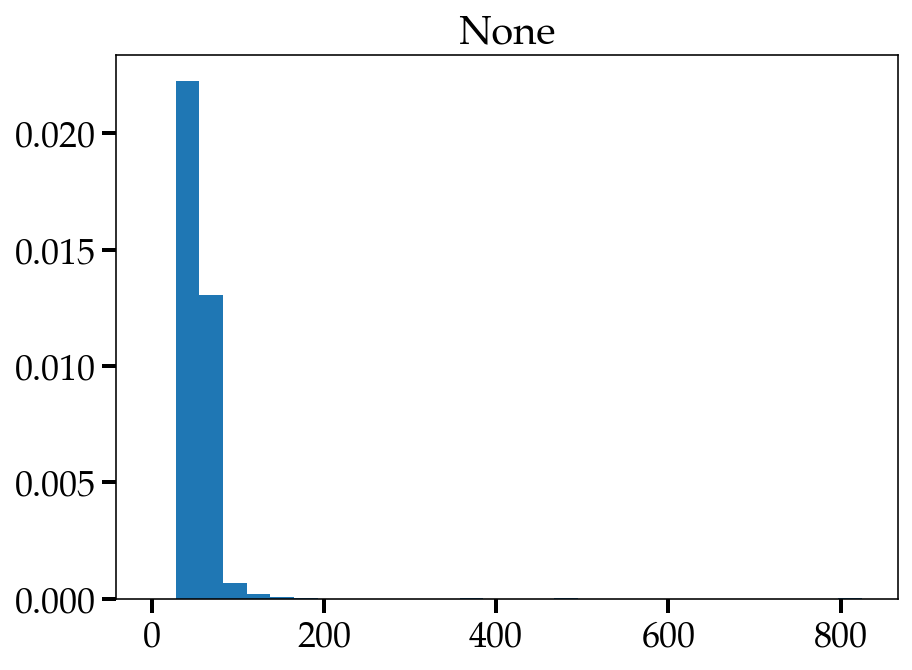

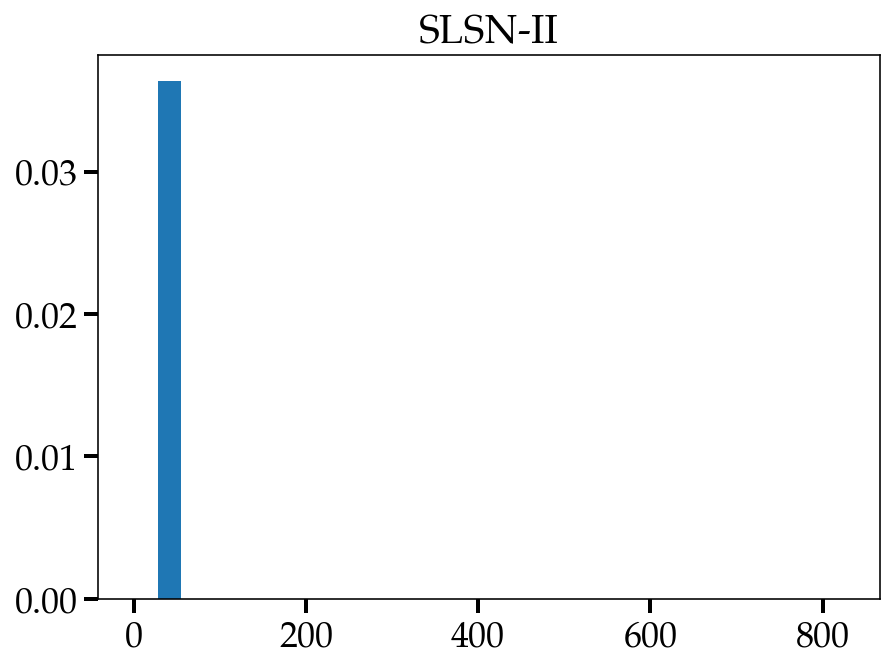

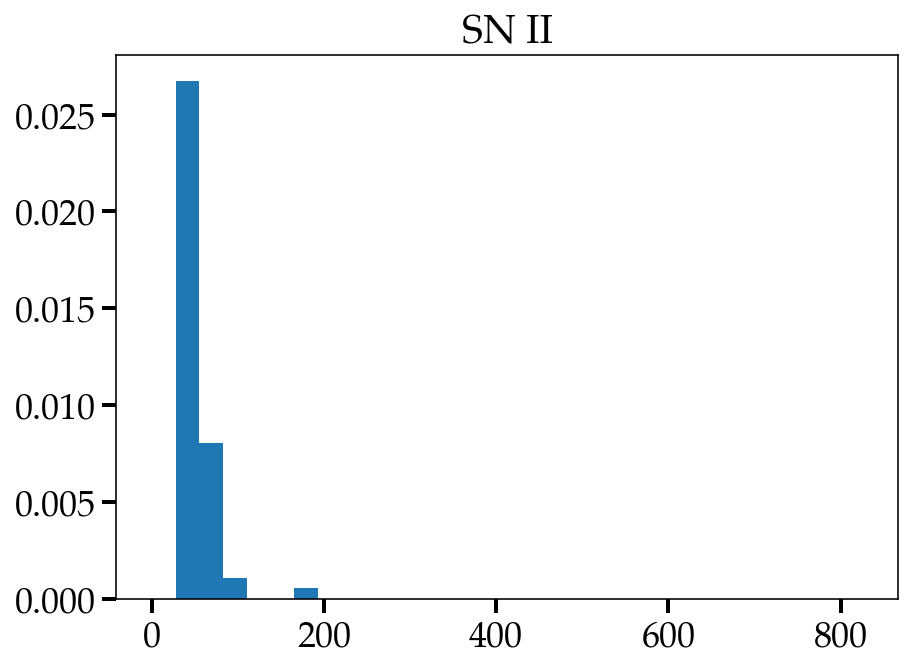

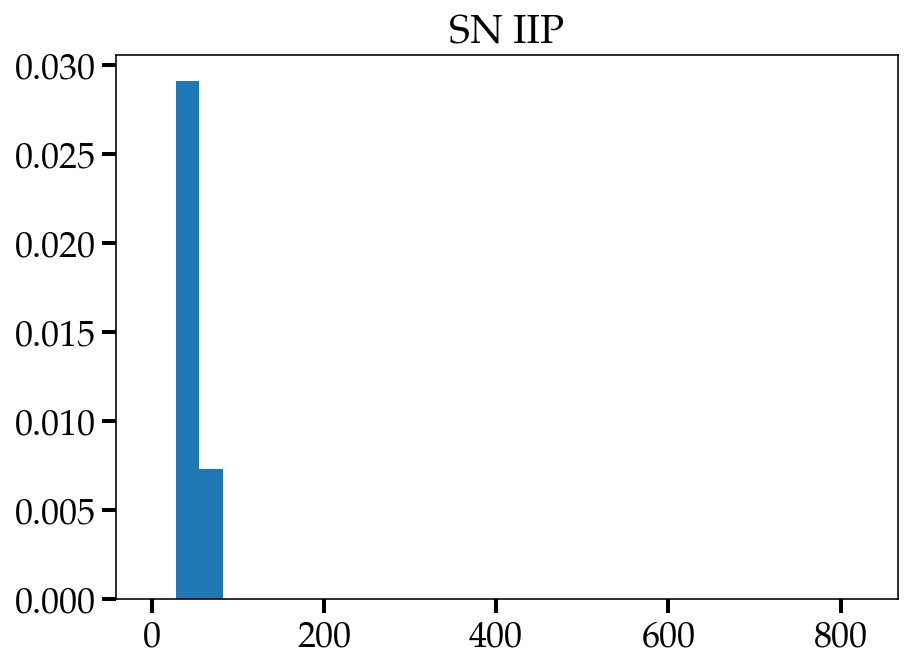

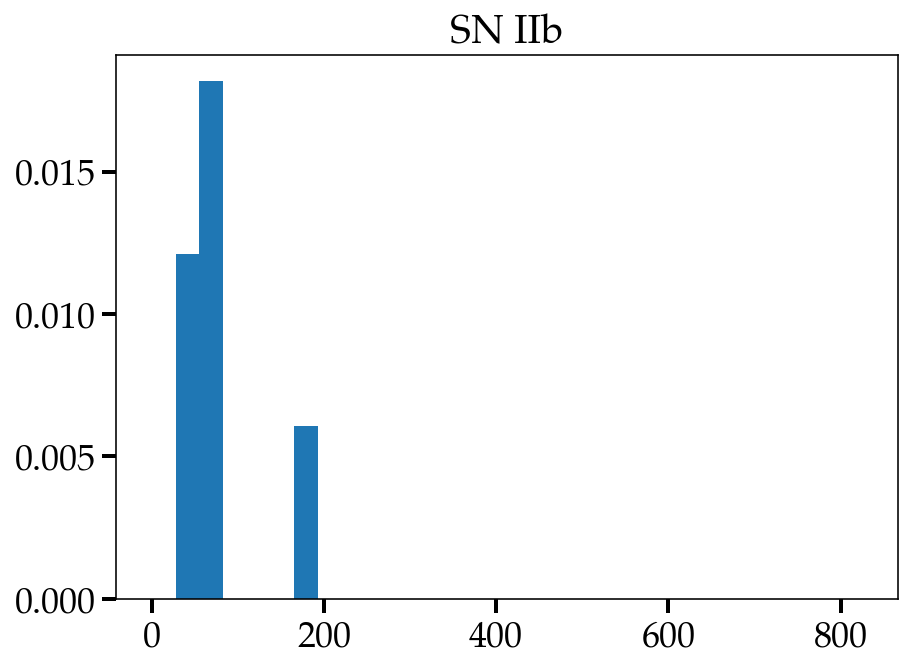

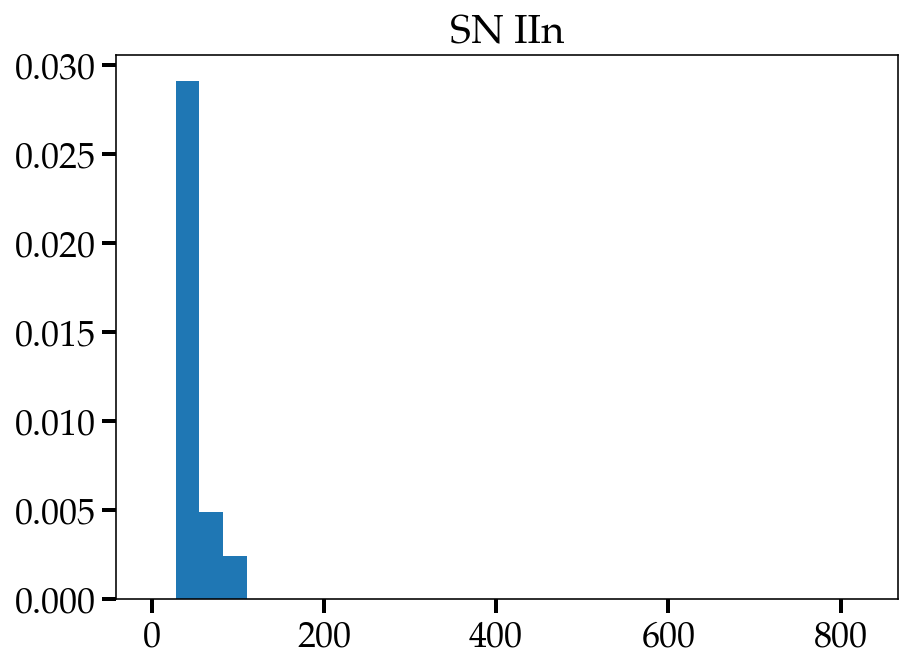

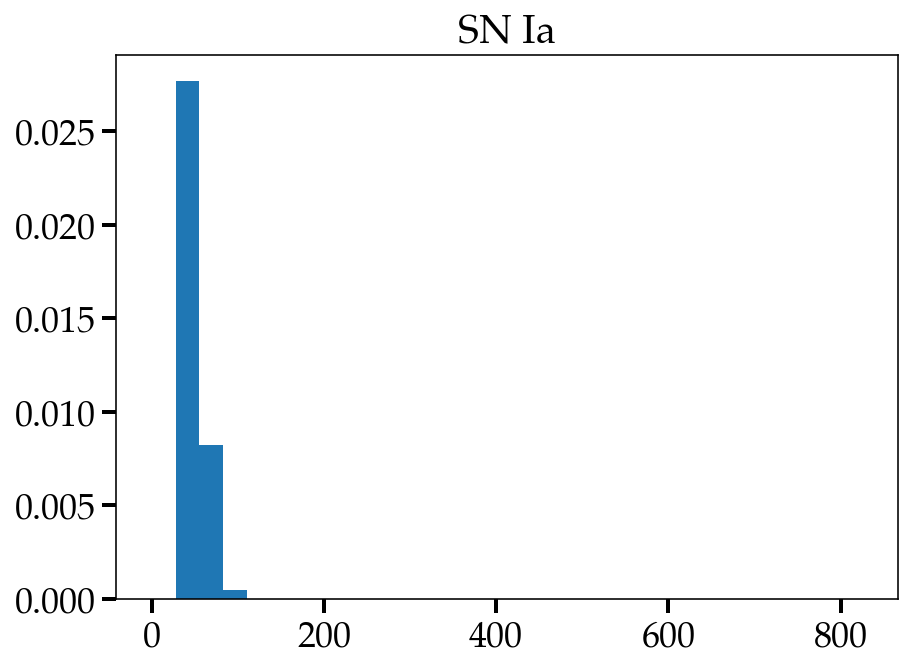

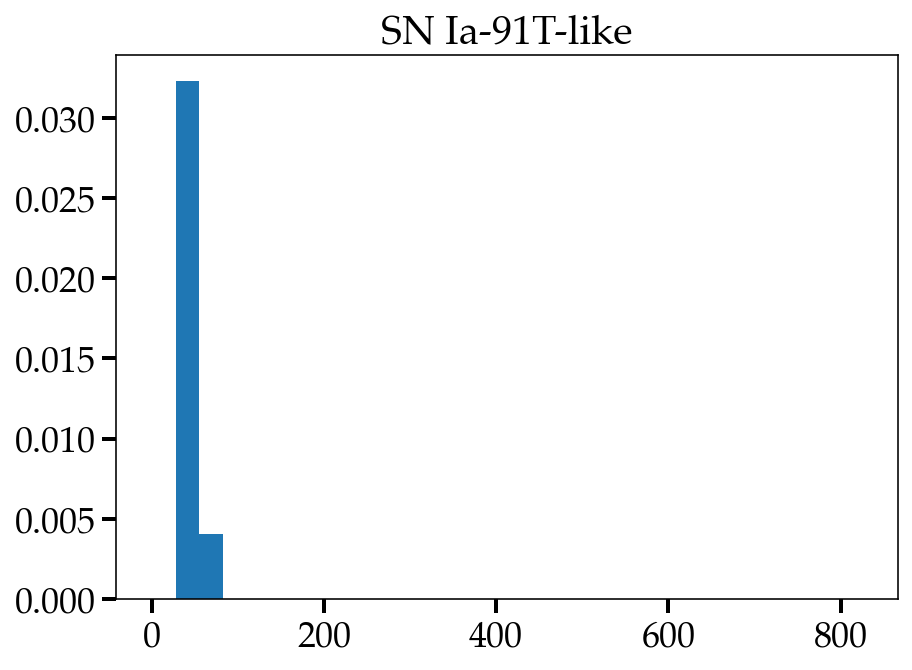

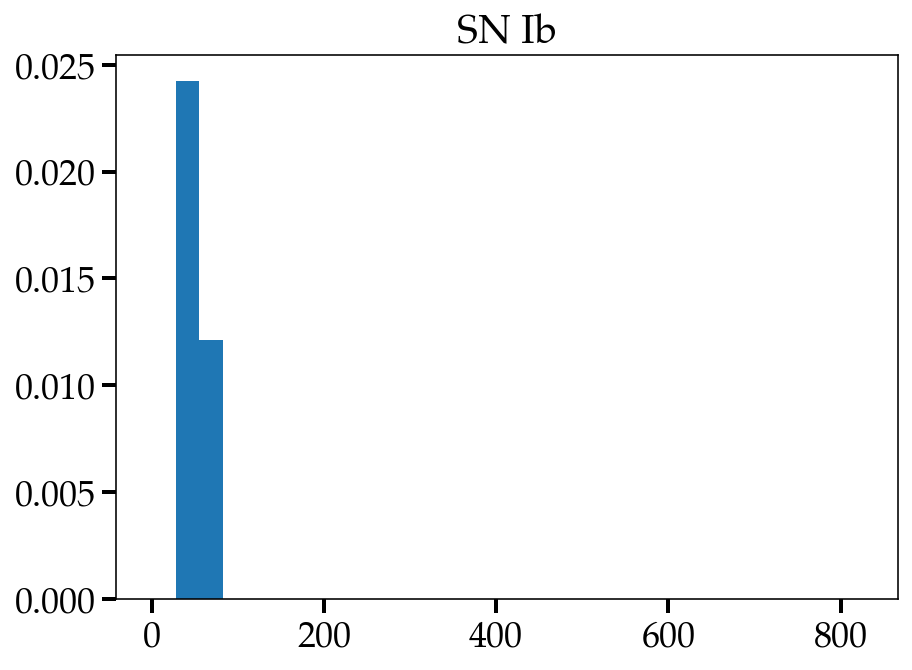

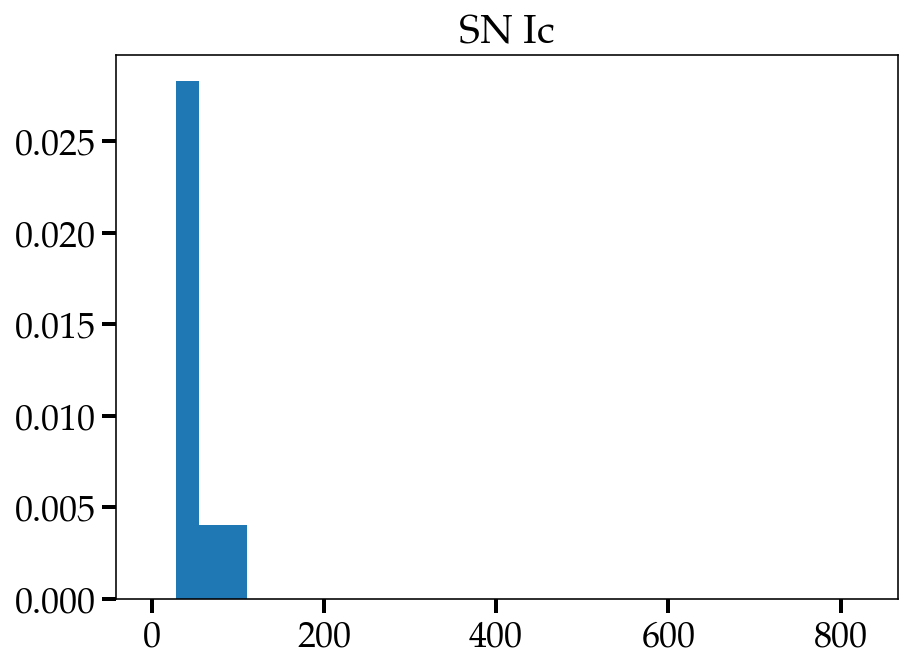

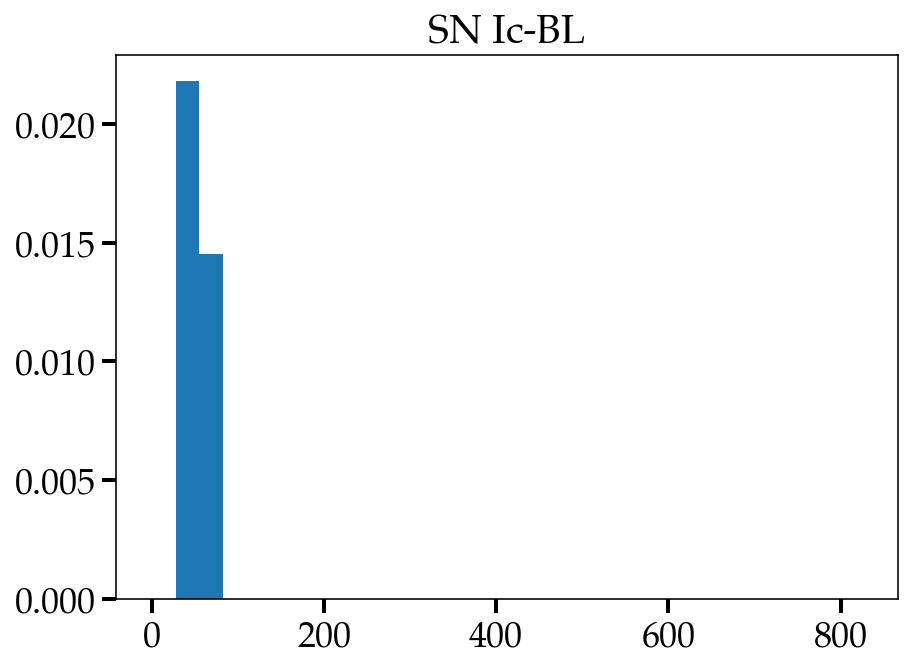

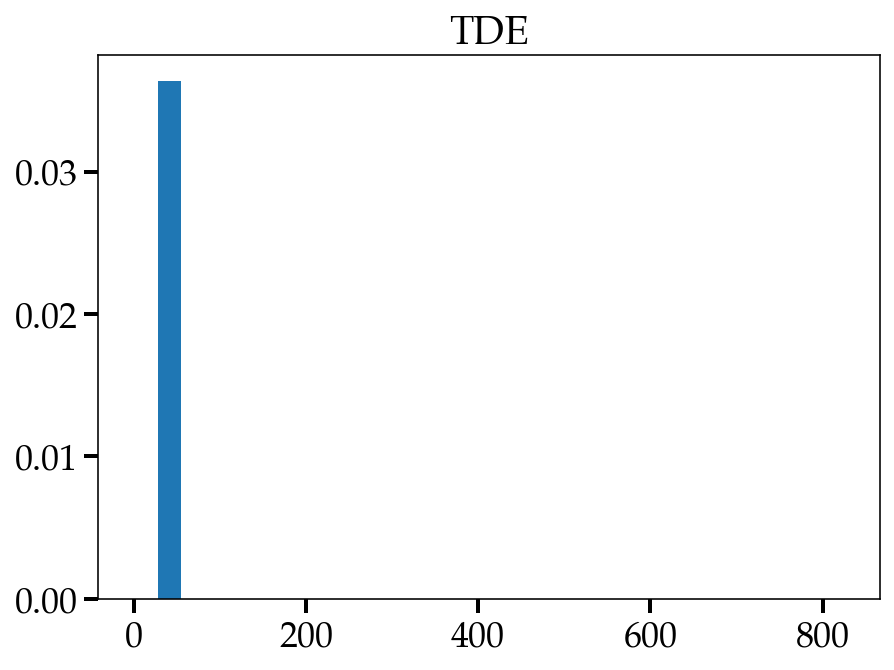

In [6]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

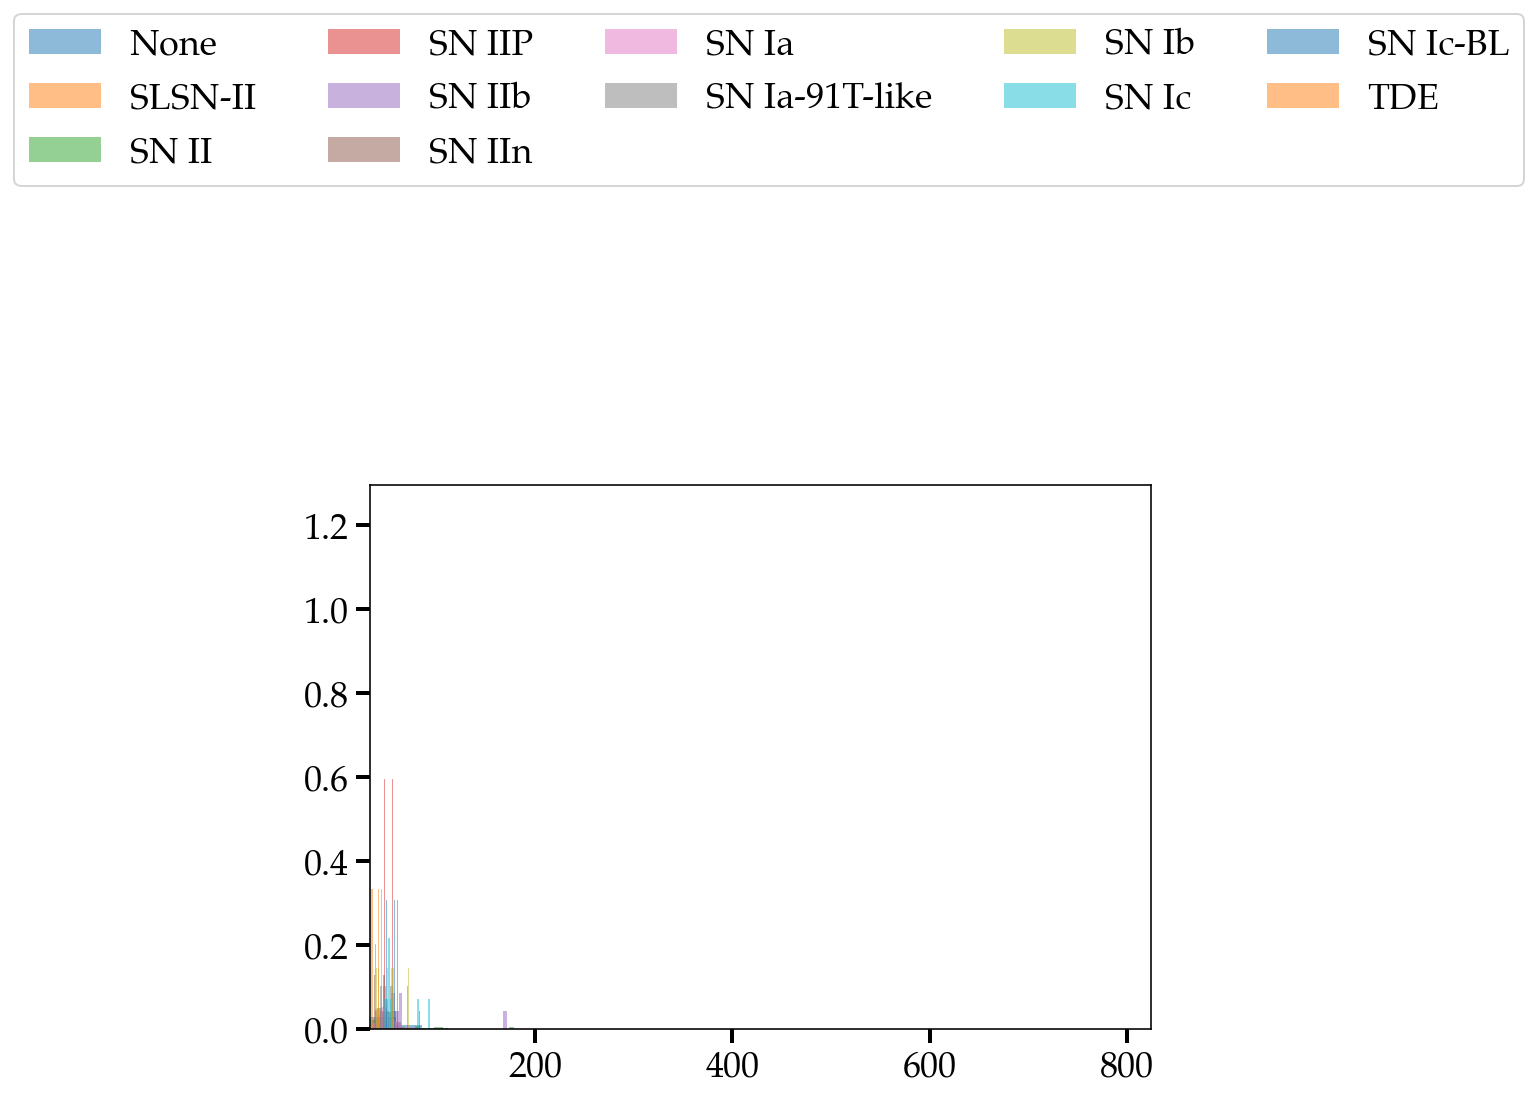

In [7]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

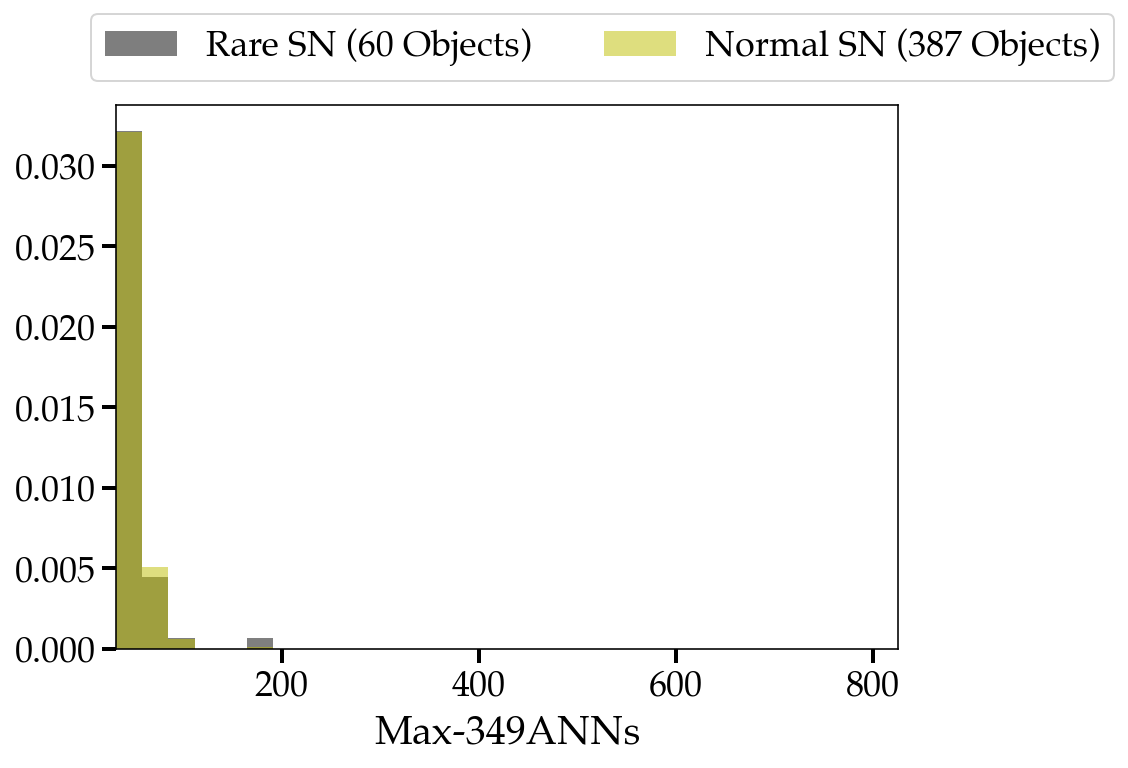

In [8]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [9]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.13333333333333333
P-value: 0.6892826170531057
The two distributions are likely the same.


In [10]:
np.median(normal_sn_df[dist_col])

47.475528717041016

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


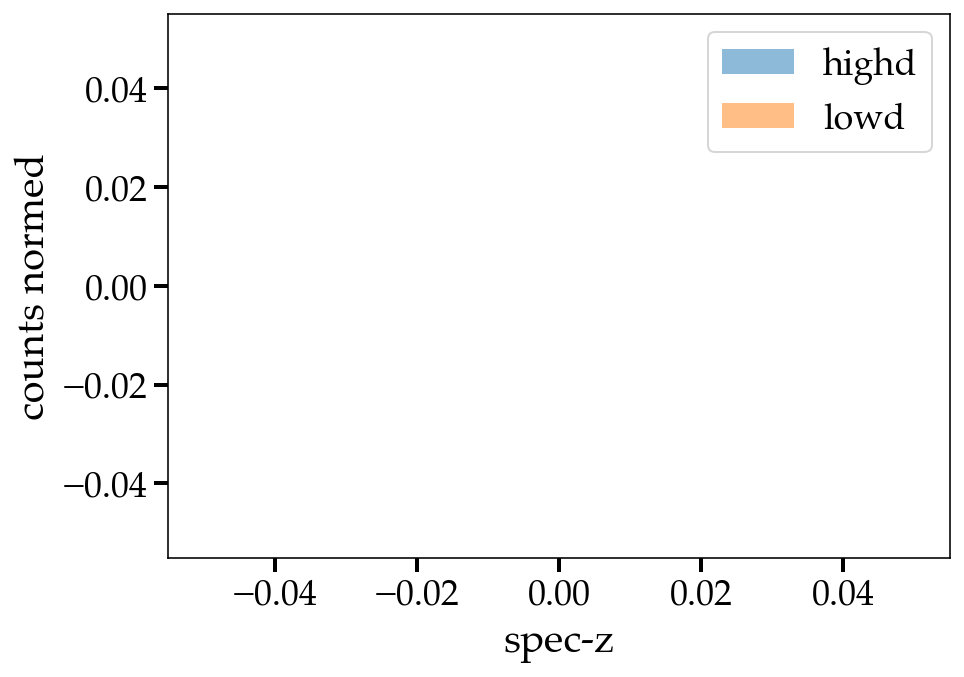

In [11]:
normal_sn_df = normal_sn_df[normal_sn_df.spec_z >= 0]

normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= np.median(normal_sn_df[dist_col])+100]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= np.median(normal_sn_df[dist_col])+100]

bins=np.linspace(np.min(normal_sn_highd_df.spec_z), np.max(normal_sn_highd_df.spec_z), 31)
plt.hist(normal_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [12]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 1.0
P-value: 1.0
The two distributions are likely the same.


In [13]:
np.median(rare_sn_df[dist_col])

48.10505294799805

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


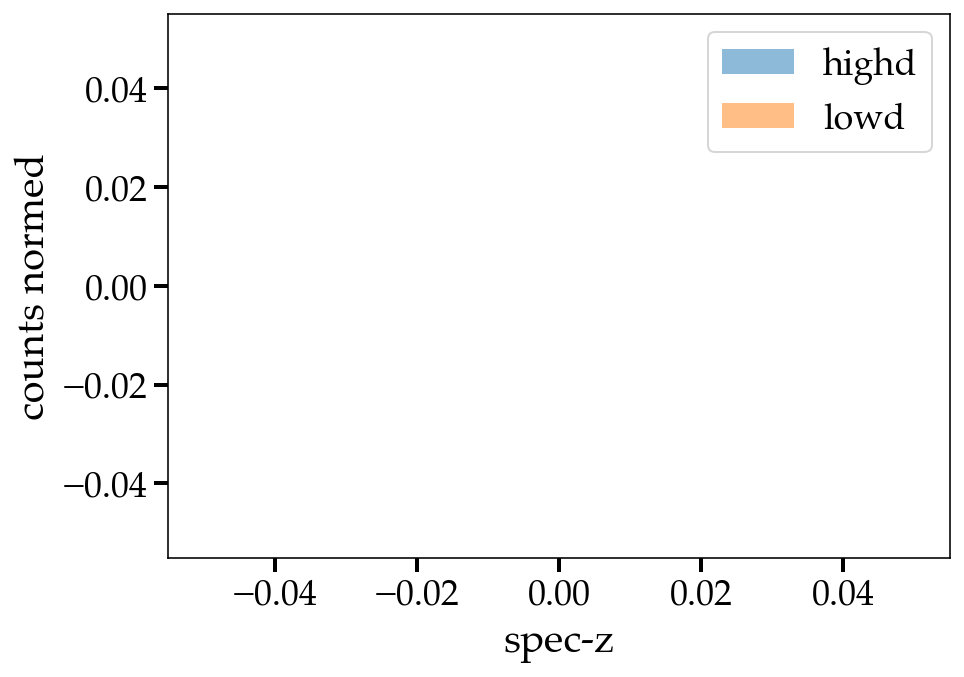

In [14]:
rare_sn_df = rare_sn_df[rare_sn_df.spec_z >= 0]

rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= np.median(rare_sn_df[dist_col])+100]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= np.median(rare_sn_df[dist_col])+100]

bins=np.linspace(np.min(rare_sn_highd_df.spec_z), np.max(rare_sn_highd_df.spec_z), 31)
plt.hist(rare_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [15]:
len(rare_sn_lowd_df)

59

In [16]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 1.0
P-value: 1.0
The two distributions are likely the same.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

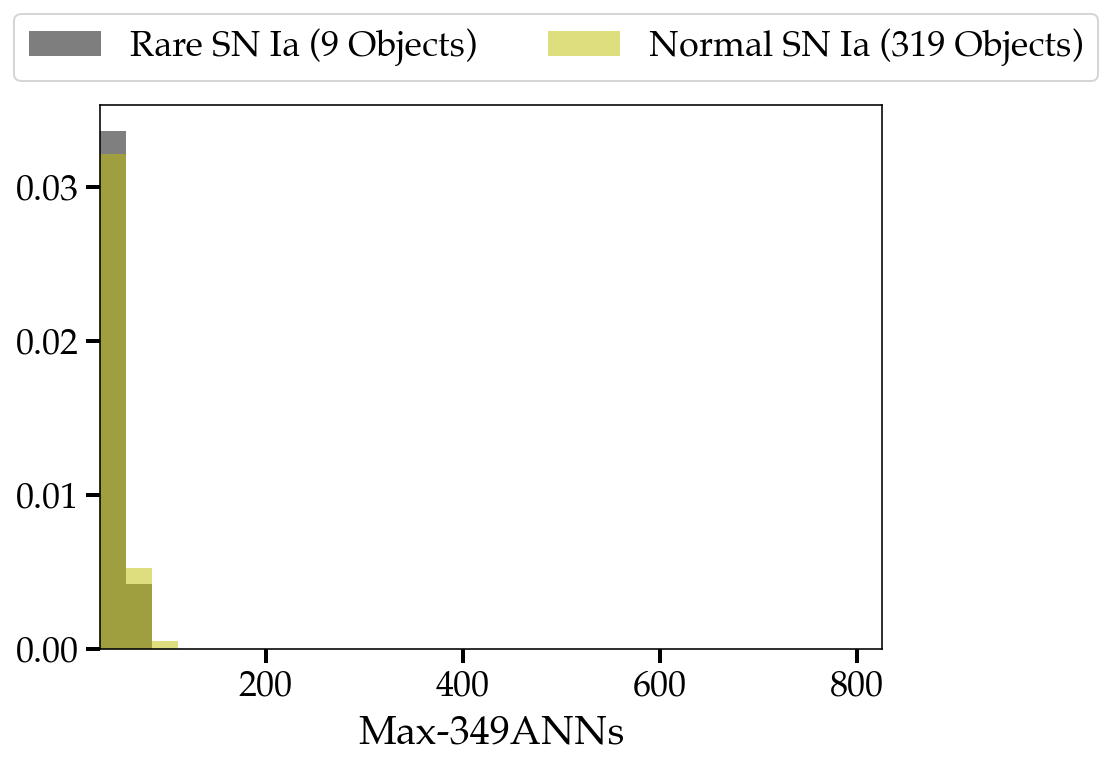

In [17]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [18]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.3333333333333333
P-value: 0.7974803373097491
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [19]:
np.median(normal_snIa_df[dist_col])

47.475528717041016

In [20]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= np.median(normal_snIa_df[dist_col])+100]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= np.median(normal_snIa_df[dist_col])+100]

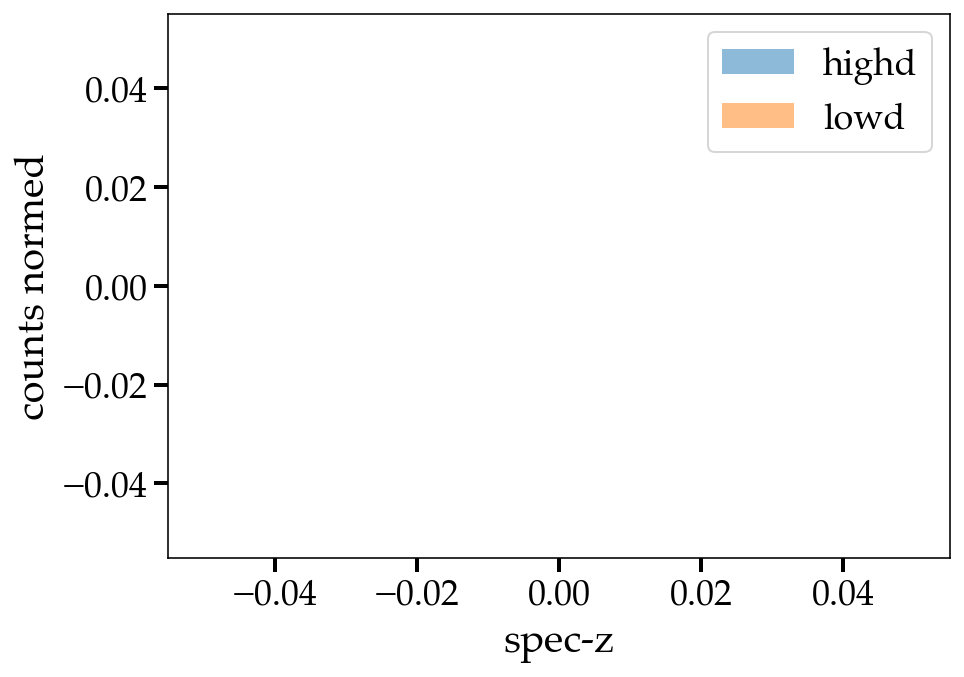

In [21]:
normal_snIa_highd_df = normal_snIa_highd_df[normal_snIa_highd_df.spec_z >= 0]

bins=np.linspace(np.min(normal_snIa_highd_df.spec_z), np.max(normal_snIa_highd_df.spec_z), 31)
plt.hist(normal_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [22]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

ValueError: Data passed to ks_2samp must not be empty

In [ ]:
np.median(rare_snIa_df[dist_col])

In [ ]:
rare_snIa_df = rare_snIa_df[rare_snIa_df.spec_z>=0]

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= np.median(rare_snIa_df[dist_col])+100]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= np.median(rare_snIa_df[dist_col])+100]

bins=np.linspace(np.min(rare_snIa_df.spec_z), np.max(rare_snIa_df.spec_z), 31)

plt.hist(rare_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [ ]:
len(rare_snIa_highd_df)

In [ ]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [23]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../loci_dbs/alerce_cut/full_ann101_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF20aaybwth,ZTF20aaybwth,ZTFabc15843,ZTFabc80732,ZTFabc27878,ZTFabc89458,ZTFabc76879,ZTFabc55090,ZTFabc95565,ZTF21abexmbi,ZTFabc97861,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,0.1
ZTF21abhvfrj,ZTF21abhvfrj,ZTF21aarlqgt,ZTFabc40828,ZTFabc01145,ZTFabc45040,ZTFabc45112,ZTFabc82423,ZTFabc33717,ZTFabc54501,ZTFabc41496,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF20acngnvf,ZTF20acngnvf,ZTF21aahdrvq,ZTF20acusjnl,ZTF21acjeqpb,ZTF18acttqzo,ZTF20aansxav,ZTF19abeievz,ZTF21achqnfn,ZTF21achnqdo,ZTFabc78281,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF20aciucub,ZTF20aciucub,ZTFabc48284,ZTF18abscghc,ZTF21aavouex,ZTFabc19121,ZTF21aatuuiz,ZTFabc98284,ZTF21aawjiss,ZTF21aagkzxe,ZTFabc50023,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21abcfnuk,ZTF21abcfnuk,ZTFabc32968,ZTFabc77151,ZTFabc41315,ZTFabc37219,ZTFabc89740,ZTFabc56219,ZTFabc98323,ZTFabc06057,ZTF21aagrhot,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,ZTF20acupxyy,ZTFabc46574,ZTFabc39788,ZTFabc87577,ZTFabc20810,ZTFabc81179,ZTF21aaoglbq,ZTFabc40354,ZTFabc19936,ZTFabc93008,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21aarzxnb,ZTF21aarzxnb,ZTF21abdhbrh,ZTF20acpmeuc,ZTF21acjvkga,ZTF21aawkuqe,ZTF20acuxlgx,ZTF20acppzxx,ZTFabc45112,ZTF18acbzvow,ZTF21aaigndt,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.14,-99.00,-99.0
ZTF18acsxjhc,ZTF18acsxjhc,ZTFabc22118,ZTFabc11741,ZTF18aczersc,ZTFabc69059,ZTFabc53861,ZTFabc38391,ZTFabc97081,ZTFabc07540,ZTFabc08966,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21aatklhw,ZTF21aatklhw,ZTFabc08837,ZTFabc24314,ZTFabc29227,ZTFabc17433,ZTFabc28849,ZTFabc81455,ZTFabc03685,ZTFabc82625,ZTFabc14853,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,0.09,-99.0


In [24]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 303:404]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20aaybwth,None,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN II,SN IIn,None,SN IIn,...,None,SN II,SN II,None,SN IIn,SN IIn,SN IIn,None,TDE,SN Ia
ZTF21abhvfrj,None,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN Ia,SN II,SN IIb,SN IIn,SN IIn,SN Ia-91T-like,None,SN IIn,SN IIn,None
ZTF20acngnvf,None,None,None,None,None,None,None,None,None,SN IIn,...,SLSN-II,SN IIn,None,SLSN-II,SLSN-II,SN IIn,SLSN-II,None,SLSN-II,SLSN-II
ZTF20aciucub,None,SN II,None,None,SN Ia,None,SN Ia,SN Ia,None,SN II,...,SN IIP,SN Ia,SN IIP,SN Ic-BL,SN IIP,SN IIP,None,SN IIP,SN II,SN IIP
ZTF21abcfnuk,None,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIn,SN IIn,None,SN Ia-91T-like,SN IIn,SN Ia,SN IIn,SN Ia,SN IIn,SN IIn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,None,TDE,TDE,TDE,TDE,TDE,None,TDE,TDE,TDE,...,SN II,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aarzxnb,None,None,None,None,None,None,None,SN II,None,None,...,SN Ia,SN Ia,None,SN II,SN Ia,None,SN II,SN Ia,None,None
ZTF18acsxjhc,None,SN IIn,SN IIn,None,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN II,SN II,SN IIb,SN IIb,SN Ib,SN Ib,SN IIb,SN Ib,SN Ib,SN IIb
ZTF21aatklhw,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,TDE,TDE,TDE,TDE,...,SN Ia-91T-like,SN II,TDE,SN Ia,SN Ia,SN Ia,TDE,SN Ia-91T-like,SN Ia,TDE


In [25]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 404:505]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF20aaybwth,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,0.1
ZTF21abhvfrj,-99.00000,0.067,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF20acngnvf,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF20aciucub,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,0.13,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21abcfnuk,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,0.1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21aarzxnb,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.14,-99.00,-99.0
ZTF18acsxjhc,-99.00000,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21aatklhw,0.06689,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.000,-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,0.09,-99.0


In [26]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_num = 101
ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, ann_num)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
ZTF20aaybwth,None,"[SN II, SN IIn, SN IIn, SN IIn, SN IIn, SN II,..."
ZTF21abhvfrj,None,"[SN II, SN II, SN II, SN II, SN II, SN II, SN ..."
ZTF20acngnvf,None,"[None, None, None, None, None, None, None, Non..."
ZTF20aciucub,None,"[SN II, None, None, SN Ia, None, SN Ia, SN Ia,..."
ZTF21abcfnuk,None,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
...,...,...
ZTF20acupxyy,None,"[TDE, TDE, TDE, TDE, TDE, None, TDE, TDE, TDE,..."
ZTF21aarzxnb,None,"[None, None, None, None, None, None, SN II, No..."
ZTF18acsxjhc,None,"[SN IIn, SN IIn, None, SN IIn, SN IIn, SN IIn,..."
ZTF21aatklhw,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, TDE, TDE, ..."


In [27]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-91T-like']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aamucom,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN IIb,...,SN Ic-BL,SN IIb,SN IIb,SN Ic-BL,SN IIb,SN IIb,SN IIb,SN IIb,SN Ia,SN Ic-BL
ZTF20acpwjus,SN Ia-91T-like,SN II,SN II,SN II,SN II,SN II,SN Ia,SN II,SN Ia,TDE,...,TDE,TDE,TDE,SN Ia,SN Ia-91T-like,TDE,TDE,TDE,TDE,TDE
ZTF21aagtqgz,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN IIb,SN IIb,SN II,SN IIb,SN IIb,...,SN Ia-91T-like,SN Ib,SN Ia,SN IIb,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN IIb,SN Ic,SN Ib
ZTF20acjdhof,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ib,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like
ZTF21aasgcve,SN Ia-91T-like,None,SN Ia,SN Ia,SN II,SN II,SN II,SN II,SN II,TDE,...,TDE,TDE,SN II,TDE,TDE,TDE,SN II,SN II,SN Ia,TDE
ZTF21aaahyjj,SN Ia-91T-like,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN IIb,SN Ia,SN Ia,SN IIb,SN IIb,SN IIn,SN IIb,SN Ia-91T-like,SN II,SN Ia
ZTF21acfccil,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia,SN Ia,SN Ia-91T-like,SN II,SN Ia,SN Ia,SN II,SN Ia,SN Ia-91T-like,SN II
ZTF20achrklb,SN Ia-91T-like,SN II,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN II,SN Ia,SN II,...,SN Ic,SN II,SN Ic,SN II,SN Ia-91T-like,SN II,SN Ia,SN Ia,SN Ic,SN Ic
ZTF21acdalyp,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia


In [28]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aazebgh,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,None,TDE,SLSN-II,TDE,TDE,TDE,TDE,TDE,TDE,SN Ib
ZTF19aapqqrb,SN Ia,None,None,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIP,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SLSN-II,SLSN-II,SN Ia-91T-like,SN IIP,SLSN-II
ZTF21aasbxng,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,...,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ic-BL,SN Ia,SN Ic-BL,SN IIb,SN Ia,SN Ia-91T-like,SN Ia
ZTF21aaglgcb,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,SN IIn,SN Ia,SN IIn,SN Ia,...,TDE,SLSN-II,SLSN-II,TDE,SLSN-II,SN IIn,TDE,SLSN-II,SLSN-II,TDE
ZTF21aanwfjk,SN Ia,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,...,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN IIb,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aavqphe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIb,SN Ia,SN IIb,SN Ia-91T-like,SN Ia-91T-like,SN IIn,SN Ia,SN Ia-91T-like,SN Ia,SN Ia
ZTF21abdcauj,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91T-like,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,None,SN Ia,SN Ia-91T-like
ZTF21aaetnfe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia,SN Ia,SN Ic,SN Ia,SN Ic,SN Ia,SN Ia,SN Ic,SN Ia,SN Ia-91T-like
ZTF21acgzwsc,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN Ib,SN IIb,SN IIb,SN Ib,SN IIb,SN Ib,SN Ib,SN Ib,SN IIb,SN Ib


In [29]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ic']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaygqkb,SN Ic,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN II,SN Ib,SN Ib,SN II,SN IIn,SN II,SN Ib,SN IIn,SN II,SN II
ZTF20abwxywy,SN Ic,SN II,SN II,SN II,SN IIn,SN IIn,SN IIn,SN Ia,SN Ic,SN Ic,...,SN Ic,SN IIb,SN IIb,SN II,SN IIb,SN II,SN IIb,SN Ic,SN IIb,SN Ic
ZTF20actekrw,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN II,SN II,SN II,SN Ic,SN II,...,SN Ib,SN Ic,SN Ib,SN Ic,SN Ic,SN II,SN Ic,SN Ic,SN Ib,SN Ic
ZTF20acueziy,SN Ic,SN II,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN II,SN II,...,SN IIb,SN Ic-BL,SN Ic,SN Ic,SN Ic-BL,SN Ia,SN IIb,SN Ib,SN Ic,SN Ic
ZTF20aclnplo,SN Ic,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,...,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,SN II,SN Ia-91T-like,SN IIn,SN Ia,SN Ia-91T-like,SN Ia-91T-like
ZTF21aaxtctv,SN Ic,SN Ia-91T-like,SN II,SN Ia-91T-like,SN Ia-91T-like,SN II,SN Ia-91T-like,SN Ia,SN II,SN II,...,SN Ia-91T-like,SN IIn,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ic-BL,SN Ia-91T-like,SN Ic-BL
ZTF20adadrhw,SN Ic,SN Ia,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN IIb,SN IIb,SN Ia,SN IIb,SN Ia,SN Ia,SN IIb,SN IIb,SN Ia,SN IIb
ZTF20acwofhd,SN Ic,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN II,SN Ia-91T-like,SN II,...,SN II,SN Ic,SN Ia,SN Ic,SN Ic,SN Ia,SN Ia,SN Ia-91T-like,SN Ic,SN Ic
ZTF21aayonfd,SN Ic,None,None,None,SN Ia,None,SN Ia,SN Ia-91T-like,None,SN Ia-91T-like,...,SN Ia-91T-like,None,SN Ia-91T-like,SN Ia-91T-like,SN IIb,SN Ia-91T-like,SN IIb,SLSN-II,SLSN-II,SN Ia-91T-like


In [30]:
# https://alerce.online/object/ZTF20aclnplo - small double bump Ic. LC looks Ia like. Spec is more Ic than Ia but not obvious
# https://alerce.online/object/ZTF20accoccp - lc also looks somewhat Ia ish
# 

In [31]:
Counter(graph_df['node'])

Counter({'None': 1160,
         'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

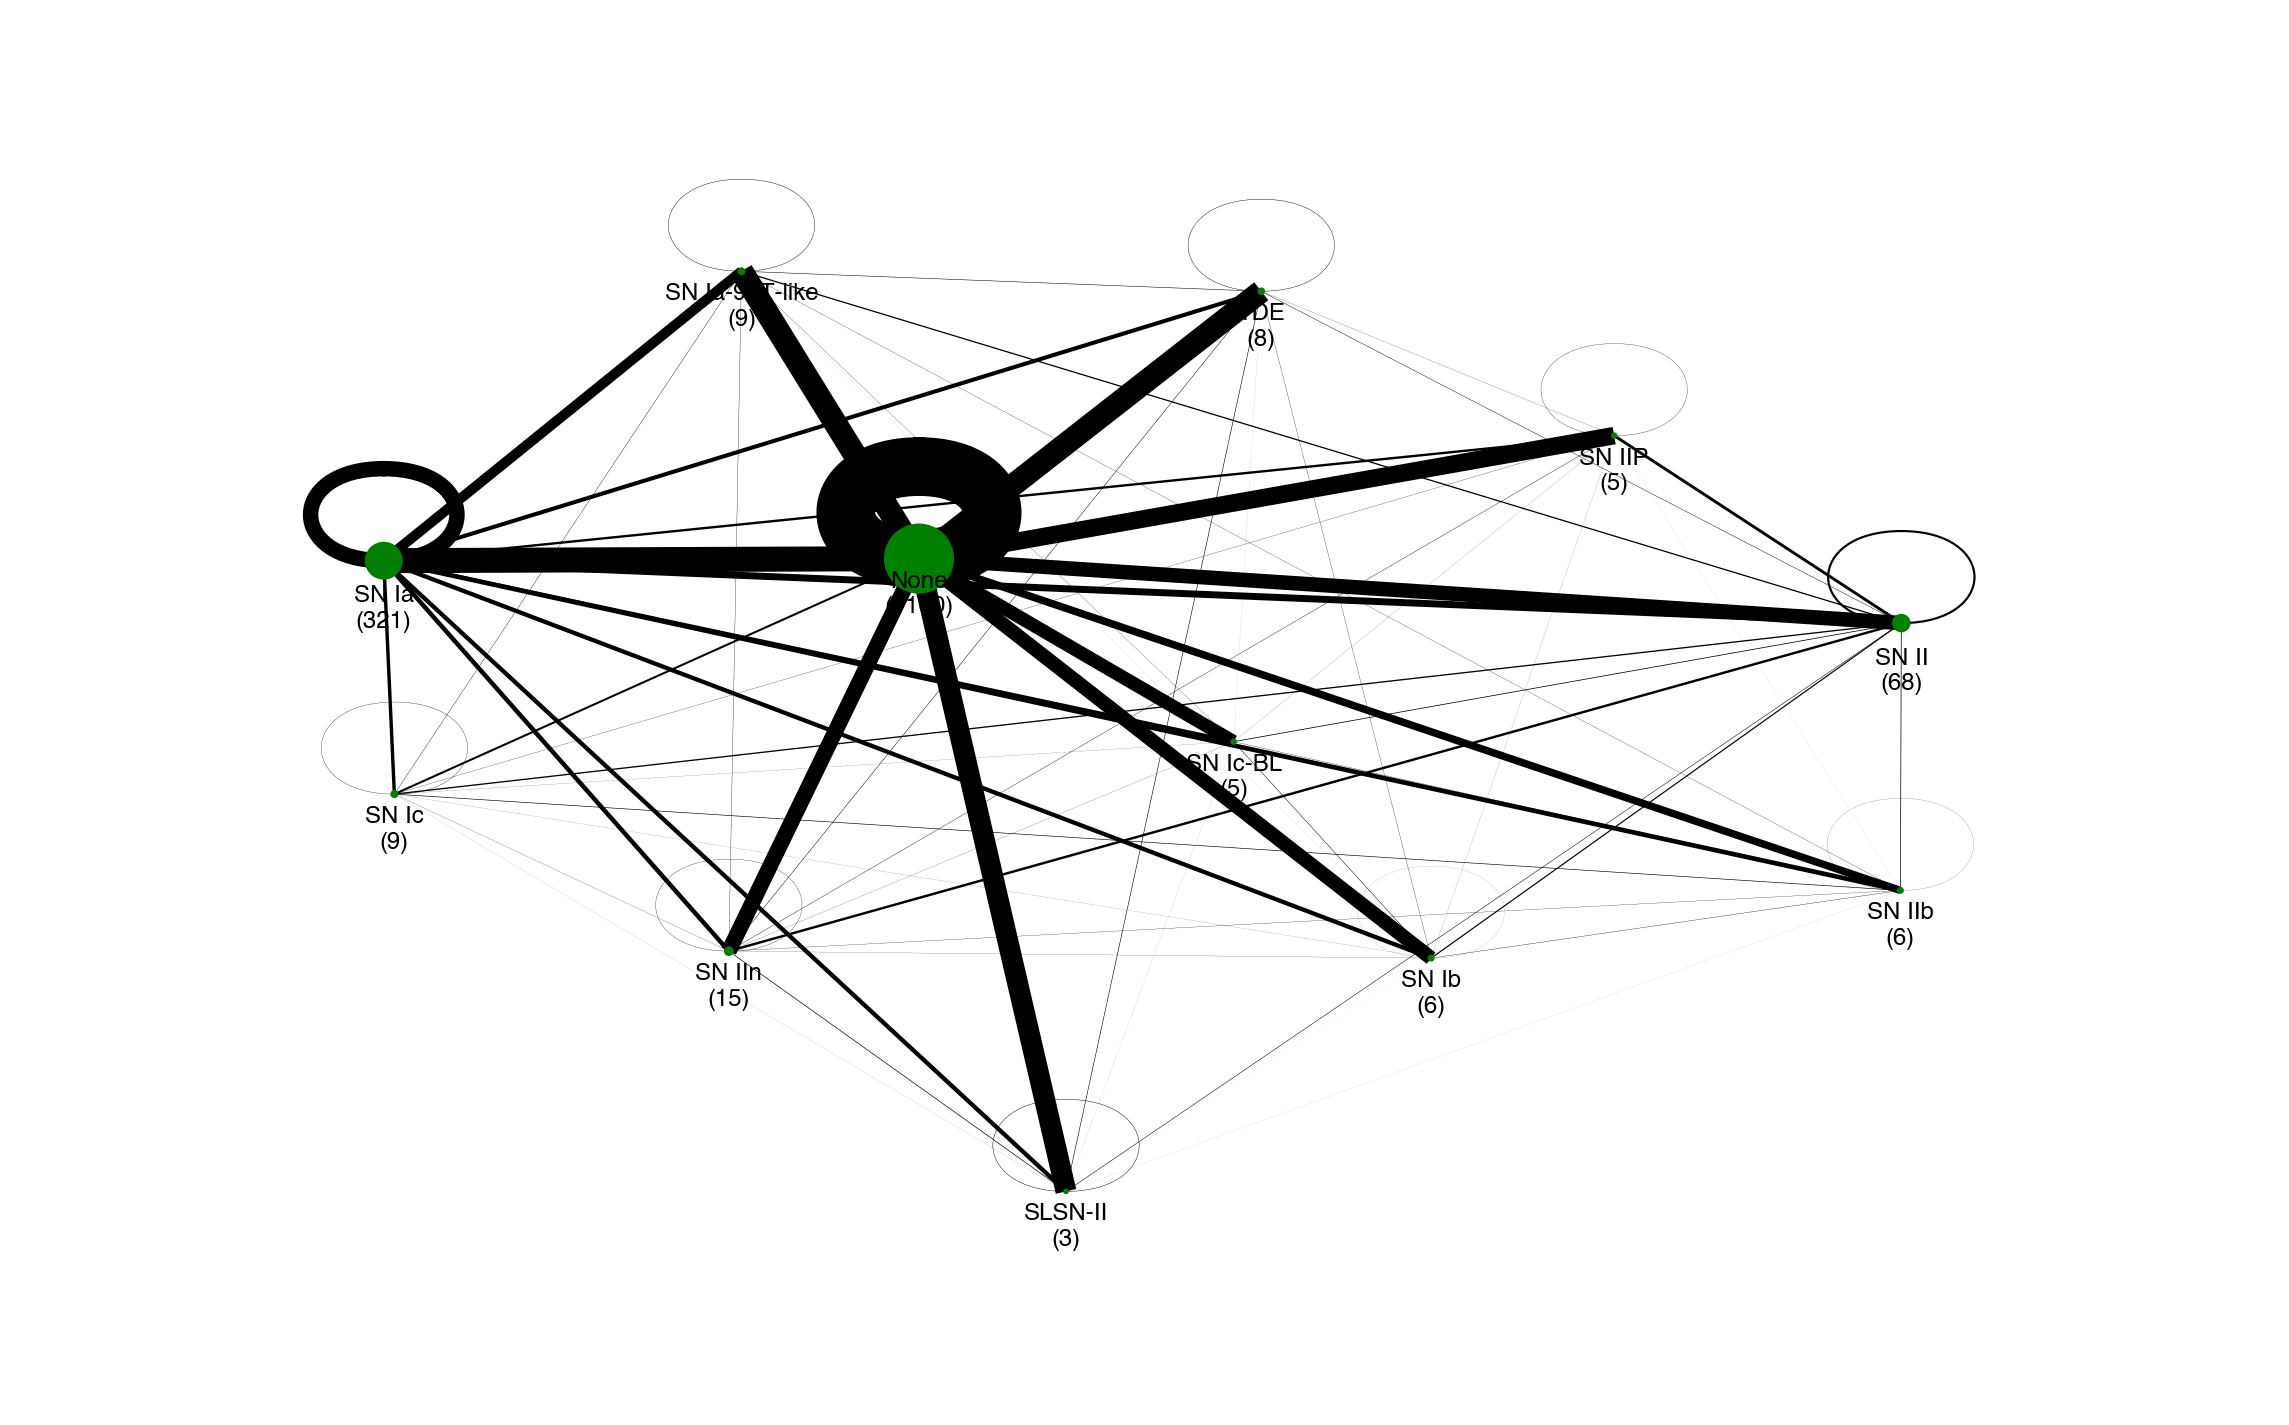

In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]

# for 80-20
# node_count.update({'SN Ibn': 0})

# for 80-20 v2
node_count.update({'SN Ibn': 0})
node_count.update({'SN Ia-91bg-like': 0})
node_count.update({'SN I': 0})
node_sizes = [node_count[node] * 1 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# # count the number of times of each node 
# node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}


node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()


folder_path = f"../figures/graphs/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'../figures/graphs/{suffix}/all_classes_network_size_scaled_ann{ann_num}.jpg', dpi=300)
plt.show()


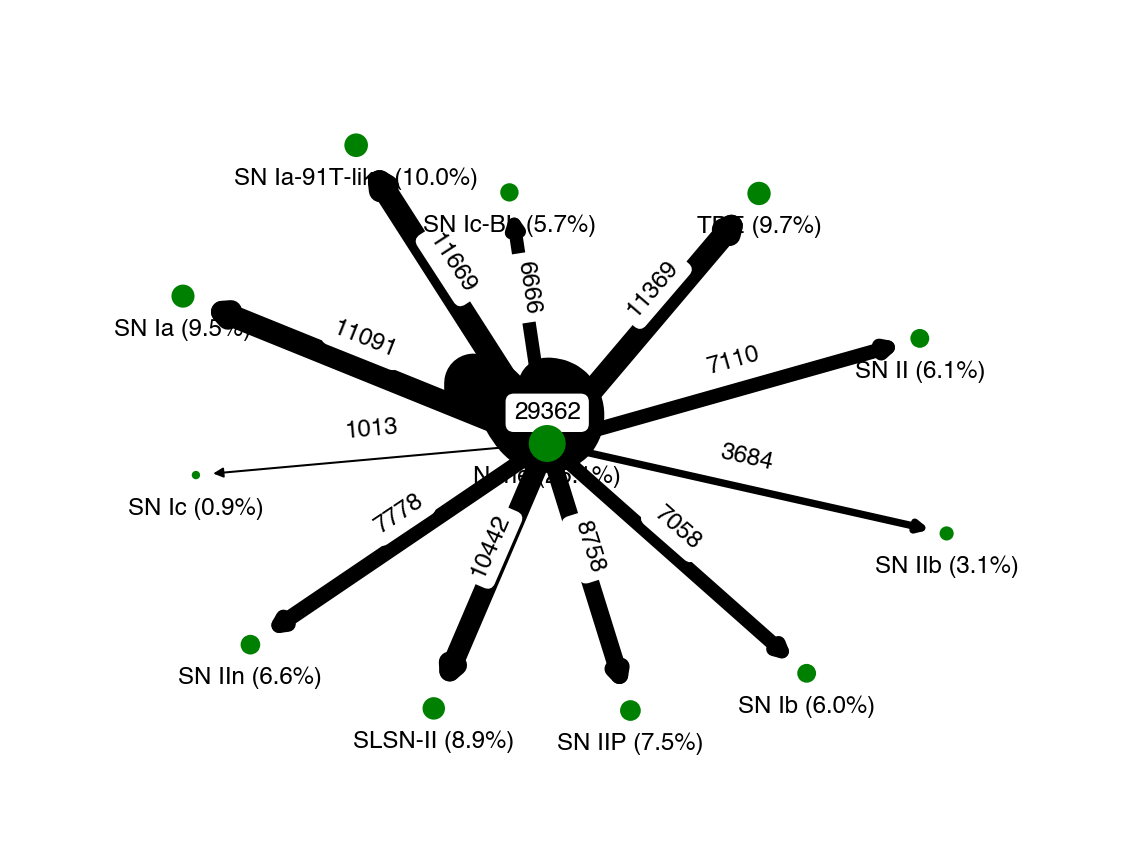

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
#True Counts
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}
#Percentage
node_counts = [node_count[node] for node in G.nodes()]
node_classes = [node for node in G.nodes()]
node_labels = {ncls: f"\n\n\n\n\n{ncls} ({round((nc/sum(node_counts))*100, 1)}%)" for ncls, nc in zip(node_classes, node_counts)}


nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


None


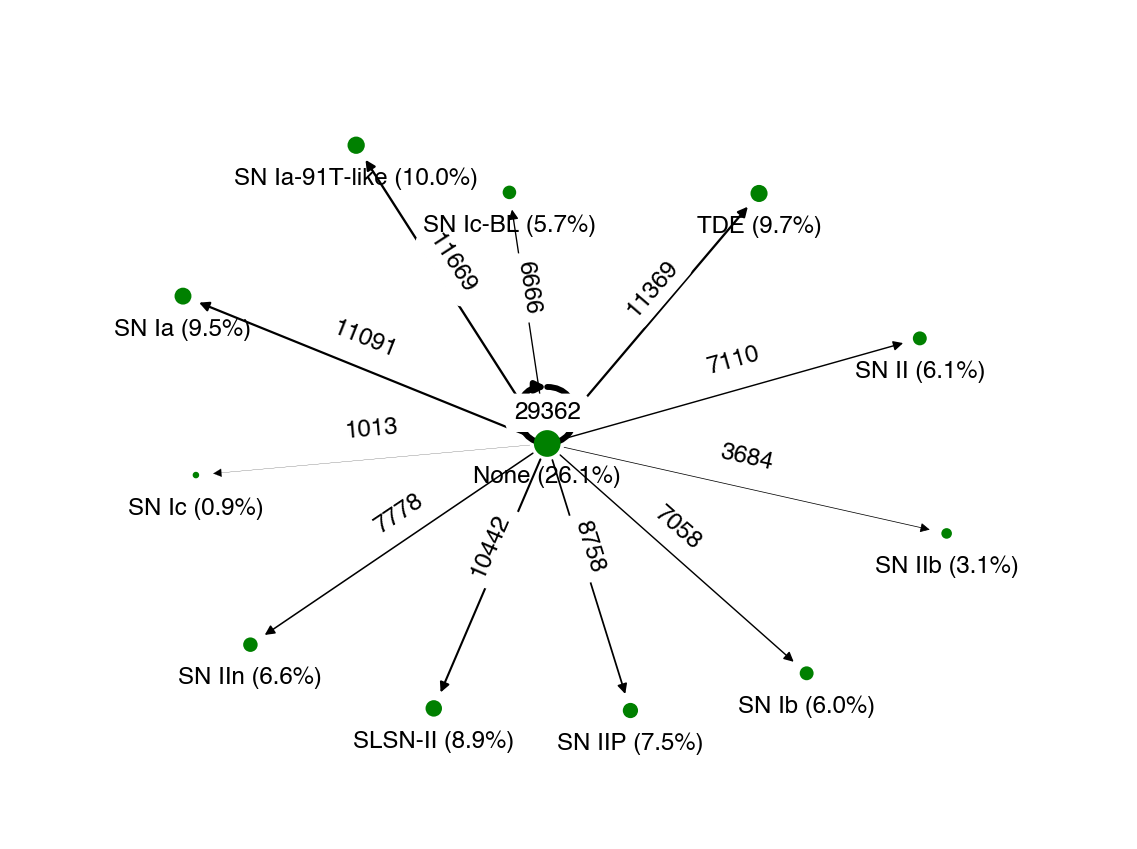

SLSN-II


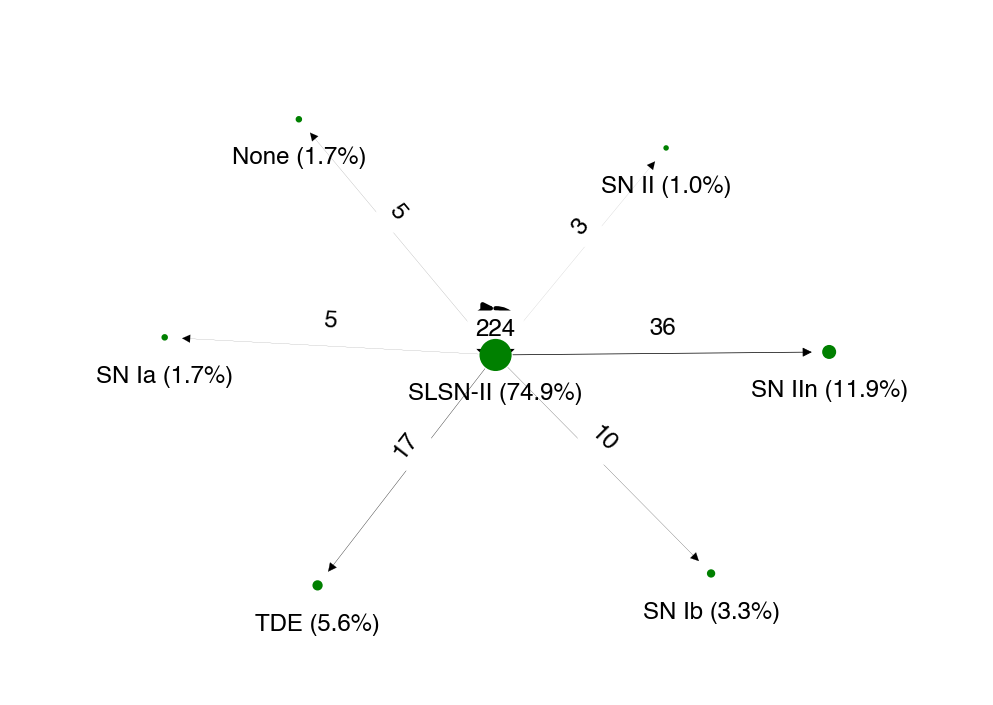

SN II


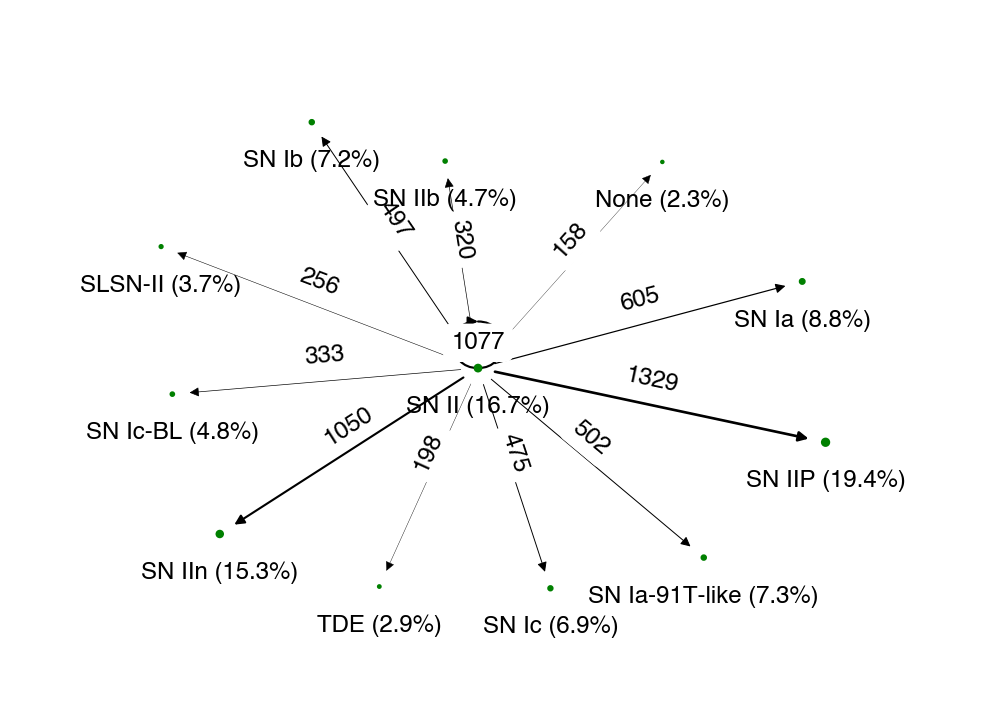

SN IIP


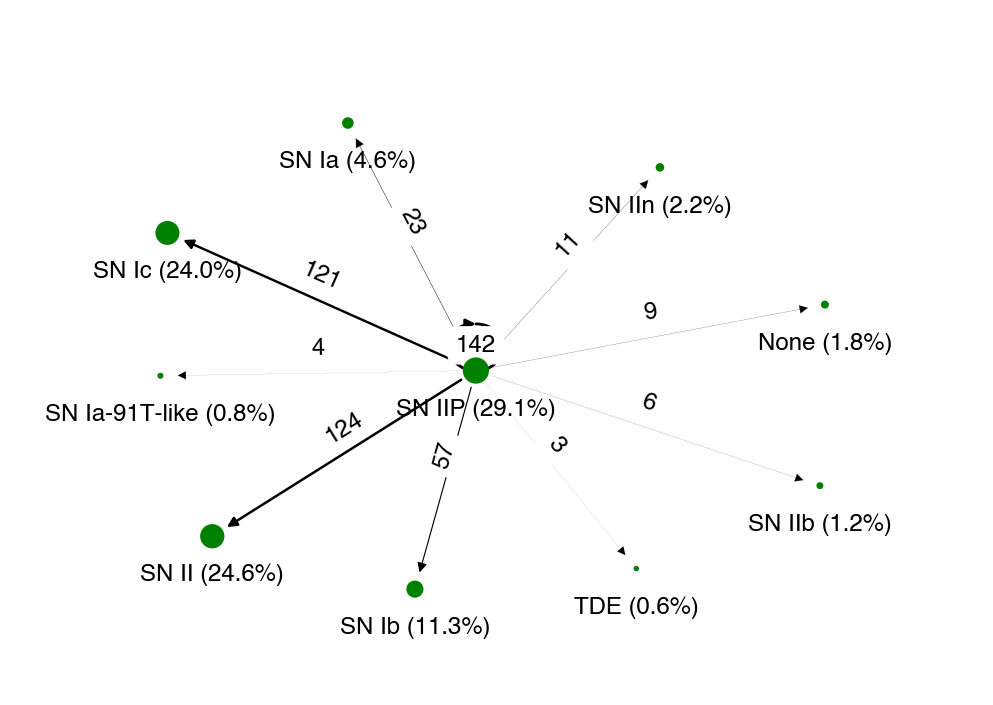

SN IIb


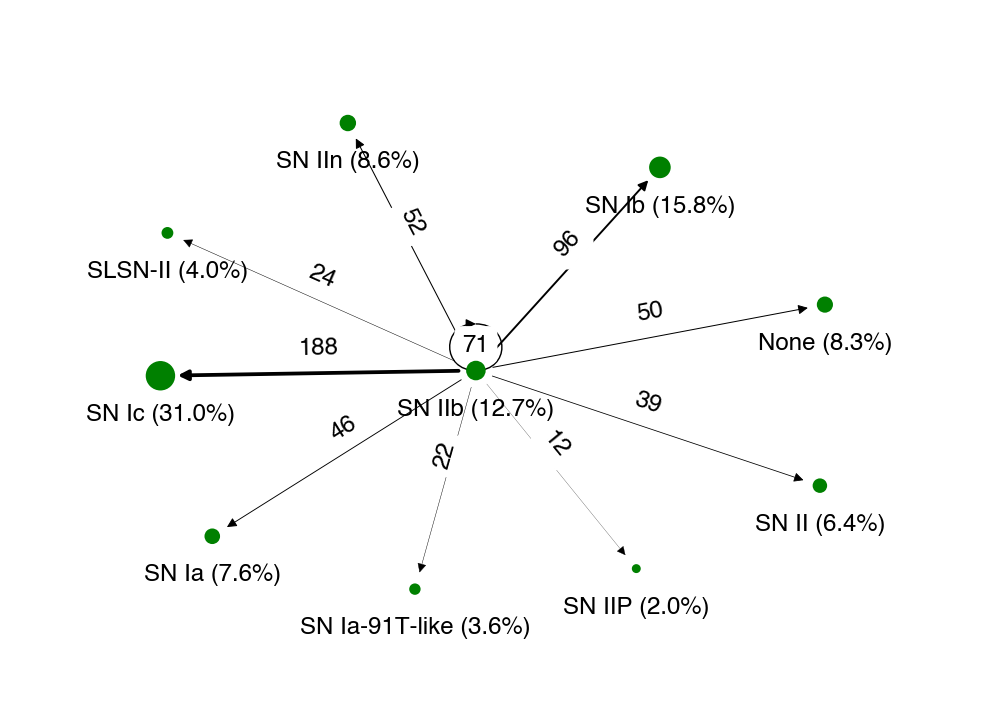

SN IIn


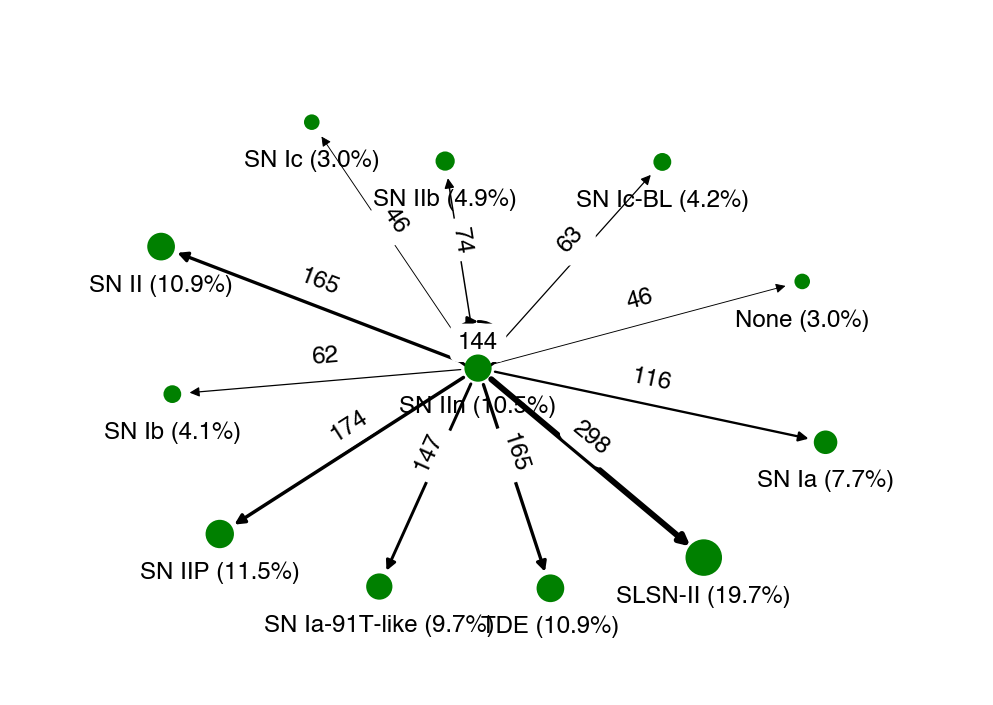

SN Ia


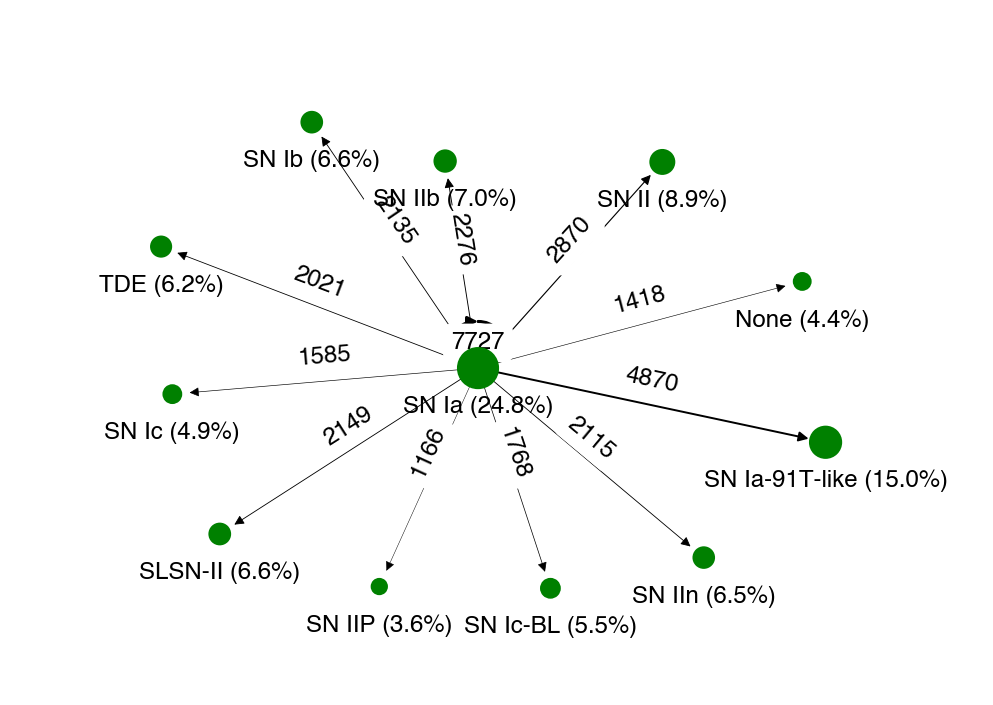

SN Ia-91T-like


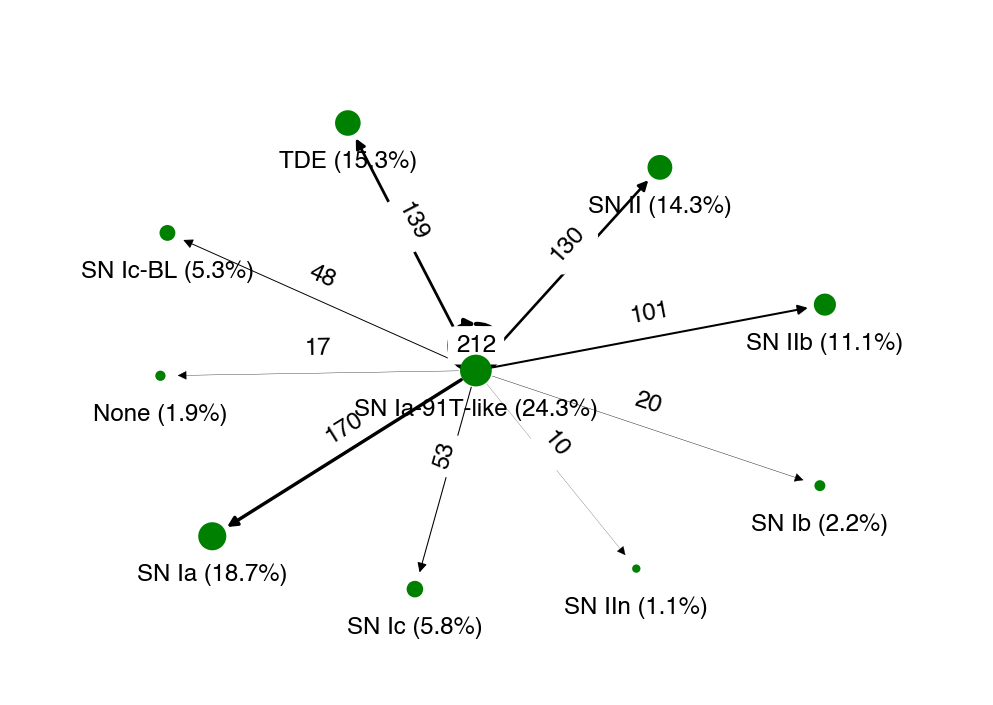

SN Ib


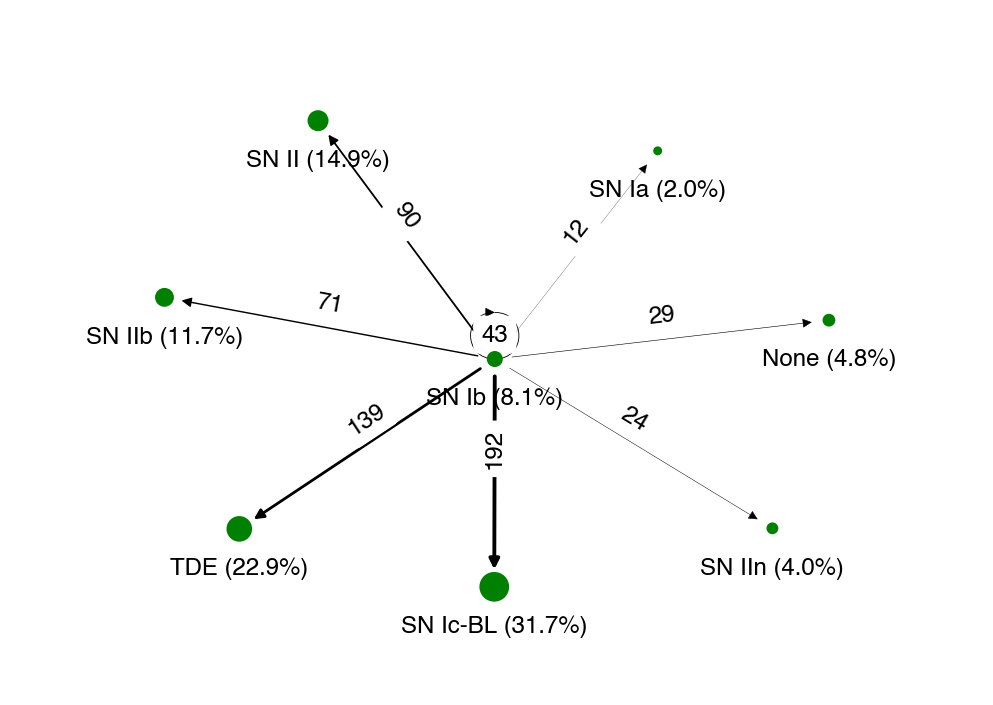

SN Ic


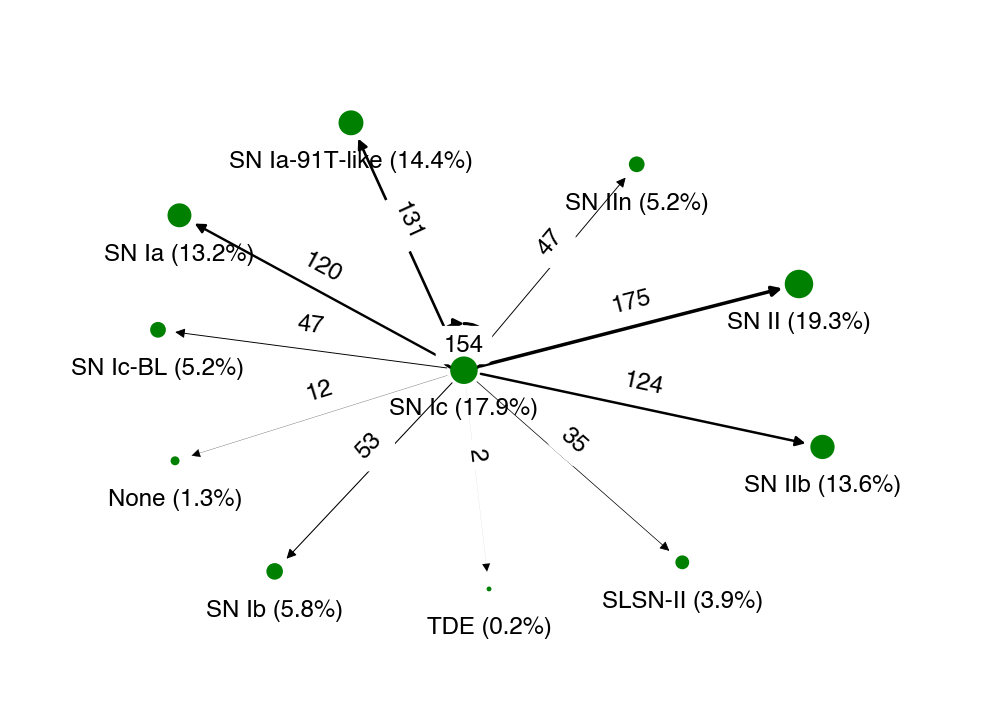

SN Ic-BL


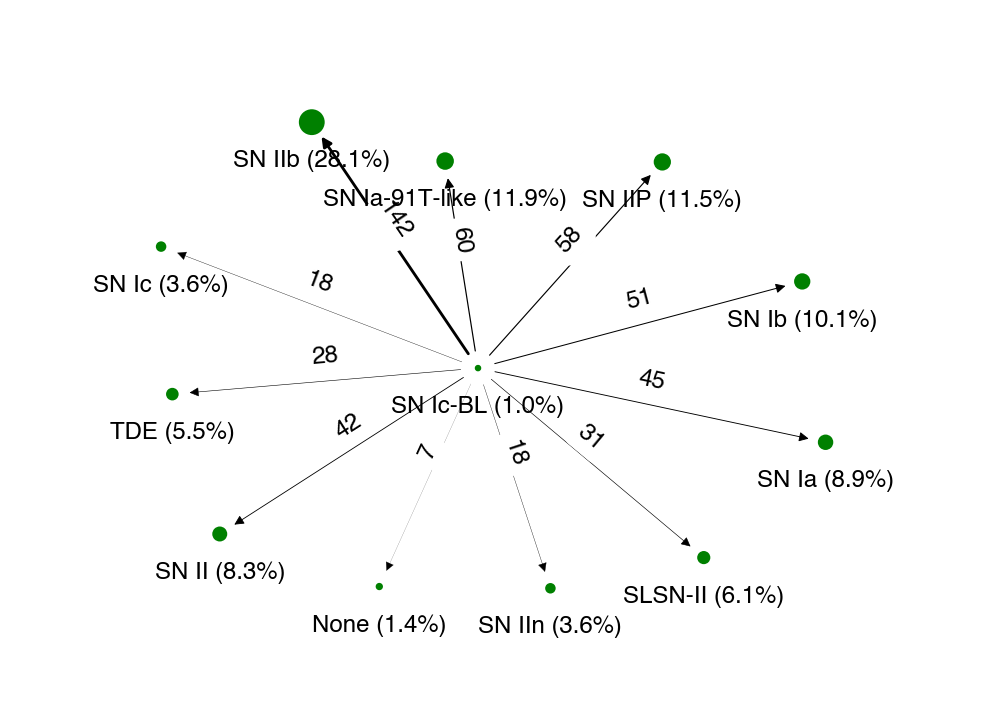

TDE


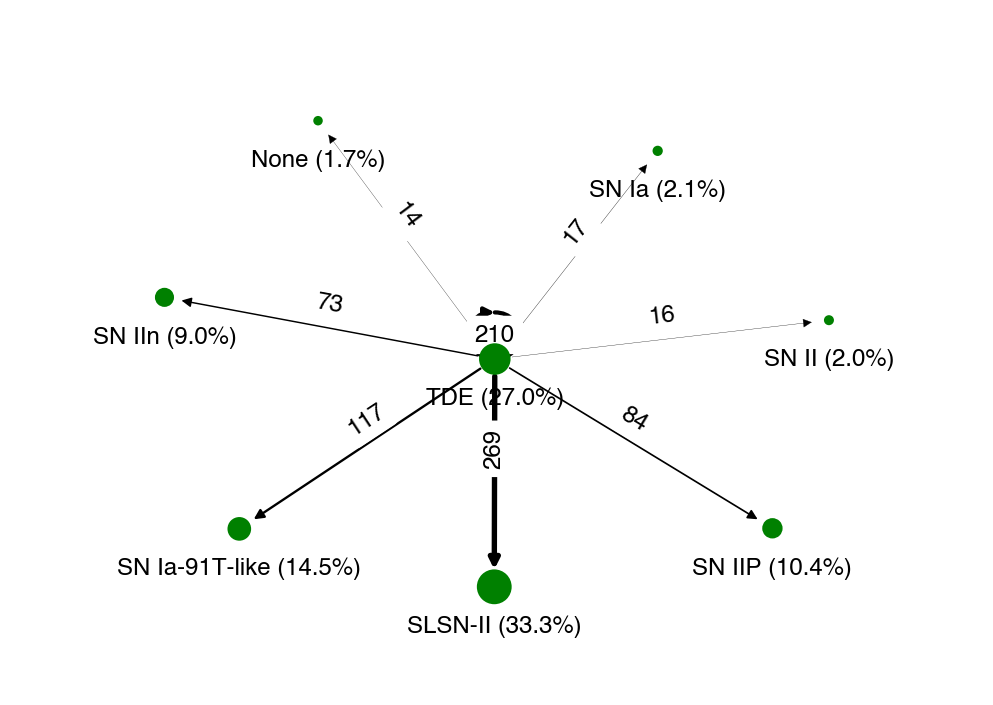

In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/5000 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/10000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.005 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 1 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    #True Counts
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}
    #Percentage
    node_counts = [node_count[node] for node in G.nodes()]
    node_classes = [node for node in G.nodes()]
    node_labels = {ncls: f"\n\n\n\n\n{ncls} ({round((nc/sum(node_counts))*100, 1)}%)" for ncls, nc in zip(node_classes, node_counts)}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    
    folder_path = f"../figures/graphs/{suffix}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    plt.savefig(f'../figures/graphs/{suffix}/size_scaled_{cls}_ann{ann_num}.jpg', dpi=300)
    plt.show()


In [35]:
Counter(full_ann_tns_cls_df['ann=0_tns_cls'])

Counter({'None': 1160,
         'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

In [36]:
def find_first_class_after_None_label_df(df, ann_num):
    # loop through each row
    for index, row in df.iterrows():
        # check if "None" is present in "ann=1_tns_cls"
        if row["ann=1_tns_cls"] == "None":
            # loop through the subsequent columns
            for col in df.columns[2:]:
                # check if the value is not "None"
                if row[col] != "None":
                    # update the value of "ann=1_tns_cls" with the first non-"None" value found
                    df.loc[index, "ann=1_tns_cls"] = row[col]
                    # break out of the loop and move to the next row
                    break
    # replace any remaining "None" values with NaN
    #df.replace("None", np.nan, inplace=True)

    df = df.iloc[:, :ann_num]
    return df

In [37]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aazebgh,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,None,TDE,SLSN-II,TDE,TDE,TDE,TDE,TDE,TDE,SN Ib
ZTF19aapqqrb,SN Ia,None,None,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIP,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SLSN-II,SLSN-II,SN Ia-91T-like,SN IIP,SLSN-II
ZTF21aasbxng,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,...,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ic-BL,SN Ia,SN Ic-BL,SN IIb,SN Ia,SN Ia-91T-like,SN Ia
ZTF21aaglgcb,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,SN IIn,SN Ia,SN IIn,SN Ia,...,TDE,SLSN-II,SLSN-II,TDE,SLSN-II,SN IIn,TDE,SLSN-II,SLSN-II,TDE
ZTF21aanwfjk,SN Ia,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,...,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN IIb,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aavqphe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIb,SN Ia,SN IIb,SN Ia-91T-like,SN Ia-91T-like,SN IIn,SN Ia,SN Ia-91T-like,SN Ia,SN Ia
ZTF21abdcauj,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91T-like,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,None,SN Ia,SN Ia-91T-like
ZTF21aaetnfe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia,SN Ia,SN Ic,SN Ia,SN Ic,SN Ia,SN Ia,SN Ic,SN Ia,SN Ia-91T-like
ZTF21acgzwsc,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN Ib,SN IIb,SN IIb,SN Ib,SN IIb,SN Ib,SN Ib,SN Ib,SN IIb,SN Ib


In [38]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter({'SN Ia': 181,
         'None': 47,
         'SN IIP': 4,
         'SN Ia-91T-like': 21,
         'SLSN-II': 6,
         'SN II': 34,
         'SN IIn': 11,
         'SN Ib': 3,
         'SN Ic': 4,
         'SN IIb': 6,
         'SN Ic-BL': 2,
         'TDE': 2})

In [39]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN II'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21abcixor,SN II,SN Ia,SN Ia,SN IIn,SN IIn,SN IIn,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,SLSN-II,SN IIn,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,SN IIn,SLSN-II,SLSN-II
ZTF21acivpbd,SN II,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,...,SN Ib,SN Ib,SN Ib,SN Ib,SN IIP,SN Ib,SN IIP,SN IIP,SN IIP,SN IIP
ZTF21achlshg,SN II,SN II,None,SN II,SN II,SN Ia,SN Ia,SN Ia,SN II,SN II,...,SN IIP,SN IIP,TDE,SN IIP,SN IIP,SN IIP,SN IIP,None,SN II,SN IIP
ZTF20achmmex,SN II,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF21abtephz,SN II,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN II,SN IIb,SN IIb,SN Ic,...,SN Ic,SN IIP,SN II,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21abpyauz,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SLSN-II,SN IIn,SN IIn,SN Ia,SN Ia,SN Ic-BL,SN II,SLSN-II,TDE,SLSN-II
ZTF21aanzcuj,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN IIn,SN IIn,SN II,SN Ic-BL,SN Ic-BL,SN II,SN Ic-BL,SN II,SN IIP,SN IIP
ZTF21abfiuqf,SN II,SN II,SN Ia,SN II,SN II,SN II,SN II,SN II,SN II,SN Ia,...,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN II,SN Ia,None,SN II,SN II
ZTF20acorjop,SN II,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,SN IIn,SN Ia,...,SLSN-II,SN Ic-BL,SLSN-II,SN IIn,SN Ic-BL,None,SN IIn,SLSN-II,SN Ic-BL,SN Ic-BL


In [40]:
len(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN II'].iloc[:, :ann_num])

68

In [41]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN II'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter({'SN Ia': 14,
         'SN Ib': 2,
         'SN II': 23,
         'SN IIP': 6,
         'SN IIb': 2,
         'SN IIn': 12,
         'SN Ic': 3,
         'SN Ia-91T-like': 1,
         'TDE': 1,
         'None': 4})

In [42]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'None'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20aaybwth,None,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN II,SN IIn,None,SN IIn,...,None,SN II,SN II,None,SN IIn,SN IIn,SN IIn,None,TDE,SN Ia
ZTF21abhvfrj,None,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN Ia,SN II,SN IIb,SN IIn,SN IIn,SN Ia-91T-like,None,SN IIn,SN IIn,None
ZTF20acngnvf,None,None,None,None,None,None,None,None,None,SN IIn,...,SLSN-II,SN IIn,None,SLSN-II,SLSN-II,SN IIn,SLSN-II,None,SLSN-II,SLSN-II
ZTF20aciucub,None,SN II,None,None,SN Ia,None,SN Ia,SN Ia,None,SN II,...,SN IIP,SN Ia,SN IIP,SN Ic-BL,SN IIP,SN IIP,None,SN IIP,SN II,SN IIP
ZTF21abcfnuk,None,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIn,SN IIn,None,SN Ia-91T-like,SN IIn,SN Ia,SN IIn,SN Ia,SN IIn,SN IIn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdrwjj,None,SN Ia,SN Ia,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,...,SLSN-II,SLSN-II,SN Ia-91T-like,SN Ia-91T-like,SLSN-II,SN Ia-91T-like,SLSN-II,SLSN-II,SN Ib,SLSN-II
ZTF20acupxyy,None,TDE,TDE,TDE,TDE,TDE,None,TDE,TDE,TDE,...,SN II,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aarzxnb,None,None,None,None,None,None,None,SN II,None,None,...,SN Ia,SN Ia,None,SN II,SN Ia,None,SN II,SN Ia,None,None
ZTF18acsxjhc,None,SN IIn,SN IIn,None,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN II,SN II,SN IIb,SN IIb,SN Ib,SN Ib,SN IIb,SN Ib,SN Ib,SN IIb


In [43]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'None'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter({'SN II': 78,
         'None': 761,
         'SN Ia': 172,
         'SLSN-II': 19,
         'TDE': 19,
         'SN Ia-91T-like': 29,
         'SN IIn': 33,
         'SN IIP': 11,
         'SN Ic-BL': 13,
         'SN Ic': 4,
         'SN IIb': 6,
         'SN Ib': 15})

In [44]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIn'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21abgkfzh,SN IIn,None,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF21achfddh,SN IIn,SN II,SN II,None,None,SN II,SN II,SN II,SN II,SN Ic-BL,...,None,SN IIP,SN IIP,SN II,SN IIP,SN IIP,SN IIP,SN II,SN IIP,SN II
ZTF20abtjjhb,SN IIn,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia,SN Ic-BL,SN Ic,SN Ia-91T-like,SN Ia,SN IIP,SN IIP,SN IIP,SN Ia,SN IIb
ZTF21aaffxdt,SN IIn,None,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,TDE,TDE,...,TDE,TDE,SN Ia-91T-like,TDE,TDE,TDE,SN Ia-91T-like,TDE,TDE,TDE
ZTF21aafmkjk,SN IIn,None,None,TDE,TDE,TDE,TDE,TDE,TDE,TDE,...,SLSN-II,SLSN-II,TDE,TDE,TDE,TDE,TDE,SLSN-II,SLSN-II,SLSN-II
ZTF19abstsvm,SN IIn,SN II,TDE,TDE,SN Ia,TDE,TDE,SN II,TDE,TDE,...,TDE,TDE,SN II,SN IIn,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aautijg,SN IIn,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF18acvgjqv,SN IIn,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF21abtdvpg,SN IIn,None,None,SN IIn,None,SN IIn,SN IIn,None,SN IIn,SN IIn,...,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN IIn,SN Ic-BL
ZTF20aczgmai,SN IIn,SN Ib,SN Ib,SN Ib,SN II,SN Ib,SN Ib,SN II,SN Ib,SN Ib,...,SN IIb,SN Ib,SN II,SN Ia,SN II,SN Ib,SN Ia,SN II,SN IIb,SN II


In [45]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIn'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter({'None': 4,
         'SN II': 3,
         'SN Ia': 4,
         'SLSN-II': 2,
         'SN Ib': 1,
         'SN IIb': 1})

# Instead of trying for 1st ANN class (or whatever is not NONE) and seeing if that is rare or NOT
# Count all class instances per row out to ANN=100, and split into majority/minority ratio
# If minority classes occur more than majority classes, call it rare
# NVM, this gives like same results...

snIIn_df = full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIn'].iloc[:, :ann_num]
snIIn_df

import pandas as pd

df = snIIn_df
df.index.name = 'ztf_object_id'

# drop rows with null values in ann=1_tns_cls column
df = df.dropna(subset=['ann=1_tns_cls'])

# majority and minority class labels
maj_labels = ['SN Ia', 'None']
min_labels = list(set(df['ann=1_tns_cls']) - set(maj_labels))

# count occurrences of each label for each object
counts = df.groupby('ztf_object_id')['ann=1_tns_cls'].value_counts()

# create a new DataFrame with the counts of each label for each object
counts_df = df.groupby('ztf_object_id')['ann=1_tns_cls'].value_counts().unstack(fill_value=0)

# determine if majority or minority class label occurs more often for each object
counts_df['label_max'] = counts_df[maj_labels].max(axis=1)
counts_df['label_min'] = counts_df[min_labels].max(axis=1)
counts_df['most_common_label'] = counts_df.idxmax(axis=1)

# determine if majority or minority class label occurs more often for each object
counts_df['label_max'] = counts_df[maj_labels].sum(axis=1) > counts_df[min_labels].sum(axis=1)
counts_df['label_max'] = counts_df['label_max'].replace({True: 'Majority', False: 'Minority'})

# print results
counts_df[['label_max', 'most_common_label']]


Counter(counts_df[['label_max', 'most_common_label']]['most_common_label'])

Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIn'].iloc[:, :ann_num]['ann=1_tns_cls'])

In [46]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIb'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21abotose,SN IIb,None,None,None,None,None,None,SN Ia,None,SN Ia,...,SN IIb,SN IIb,SLSN-II,SN Ib,SN Ia,SN IIb,SLSN-II,SN IIb,SN Ia,SN II
ZTF21aaabwfu,SN IIb,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN Ib,SN IIb,SN Ib,SN II,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb
ZTF20acusecr,SN IIb,None,SN Ia,None,None,SN Ia,None,SN Ia,None,SN Ia-91T-like,...,None,SN Ia,SN Ib,SN II,SN Ia-91T-like,SN Ia-91T-like,SN Ib,SN II,None,SN Ib
ZTF21acmrdga,SN IIb,SN Ia,SN Ia,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,...,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF20acgiglu,SN IIb,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,...,SN Ic,SN Ic,SN Ib,SN Ib,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF21aarasky,SN IIb,SN II,SN II,SN II,SN II,SN II,SN II,SN Ia,SN Ia,SN II,...,SN IIb,SN IIP,SN IIP,SN II,SN IIP,SN Ib,SN II,SN IIb,SN IIP,SN IIP


In [47]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIb'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter({'None': 2, 'SN IIn': 1, 'SN Ia': 1, 'SN Ic': 1, 'SN II': 1})

In [48]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'TDE'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acyydkh,TDE,SN II,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN IIn,SN Ia-91T-like,TDE,SN Ia-91T-like,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
ZTF21abcgnqn,TDE,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN Ia-91T-like
ZTF22aaaedas,TDE,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,SLSN-II,SLSN-II,SN IIn
ZTF21abaxaqq,TDE,SN IIn,SN IIn,SN II,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN IIn,SN IIn,SLSN-II,None,SLSN-II,SN II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF18acaqdaa,TDE,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,TDE,TDE,TDE,TDE,...,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aaaokyp,TDE,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,...,SN Ia-91T-like,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia-91T-like,SN IIn,SLSN-II,SLSN-II,SLSN-II
ZTF21aapvvtb,TDE,None,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,TDE,SN Ia-91T-like,...,SN Ia,SLSN-II,SN Ia,TDE,SN Ia-91T-like,SN Ia-91T-like,SLSN-II,SLSN-II,SLSN-II,TDE
ZTF20acwytxn,TDE,None,None,None,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,TDE,TDE,SLSN-II,TDE,SLSN-II,SLSN-II,TDE,TDE,SLSN-II,TDE


In [49]:
tde_df = full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'TDE'].iloc[:, :ann_num]
tde_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acyydkh,TDE,SN II,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN IIn,SN Ia-91T-like,TDE,SN Ia-91T-like,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
ZTF21abcgnqn,TDE,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN Ia-91T-like
ZTF22aaaedas,TDE,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,SLSN-II,SLSN-II,SN IIn
ZTF21abaxaqq,TDE,SN IIn,SN IIn,SN II,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN IIn,SN IIn,SLSN-II,None,SLSN-II,SN II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF18acaqdaa,TDE,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,TDE,TDE,TDE,TDE,...,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aaaokyp,TDE,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,...,SN Ia-91T-like,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia-91T-like,SN IIn,SLSN-II,SLSN-II,SLSN-II
ZTF21aapvvtb,TDE,None,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,TDE,SN Ia-91T-like,...,SN Ia,SLSN-II,SN Ia,TDE,SN Ia-91T-like,SN Ia-91T-like,SLSN-II,SLSN-II,SLSN-II,TDE
ZTF20acwytxn,TDE,None,None,None,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,TDE,TDE,SLSN-II,TDE,SLSN-II,SLSN-II,TDE,TDE,SLSN-II,TDE


In [50]:
find_first_class_after_None_label_df(df=tde_df, ann_num=2)

,ann=0_tns_cls,ann=1_tns_cls
ZTF20acyydkh,TDE,SN II
ZTF21abcgnqn,TDE,SN IIP
ZTF22aaaedas,TDE,SLSN-II
ZTF21abaxaqq,TDE,SN IIn
ZTF18acaqdaa,TDE,SN IIn
ZTF21aaaokyp,TDE,SLSN-II
ZTF21aapvvtb,TDE,SN Ia-91T-like
ZTF20acwytxn,TDE,SLSN-II


In [51]:
tde_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acyydkh,TDE,SN II,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN IIn,SN Ia-91T-like,TDE,SN Ia-91T-like,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
ZTF21abcgnqn,TDE,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN Ia-91T-like
ZTF22aaaedas,TDE,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,SLSN-II,SLSN-II,SN IIn
ZTF21abaxaqq,TDE,SN IIn,SN IIn,SN II,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN IIn,SN IIn,SLSN-II,None,SLSN-II,SN II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF18acaqdaa,TDE,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,TDE,TDE,TDE,TDE,...,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aaaokyp,TDE,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,...,SN Ia-91T-like,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia-91T-like,SN IIn,SLSN-II,SLSN-II,SLSN-II
ZTF21aapvvtb,TDE,SN Ia-91T-like,None,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,TDE,SN Ia-91T-like,...,SN Ia,SLSN-II,SN Ia,TDE,SN Ia-91T-like,SN Ia-91T-like,SLSN-II,SLSN-II,SLSN-II,TDE
ZTF20acwytxn,TDE,SLSN-II,None,None,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,TDE,TDE,SLSN-II,TDE,SLSN-II,SLSN-II,TDE,TDE,SLSN-II,TDE


In [52]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'TDE'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter({'SN II': 1, 'SN IIP': 1, 'SLSN-II': 2, 'SN IIn': 2, 'None': 2})

In [53]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SLSN-I'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls


In [54]:
Counter(full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SLSN-I'].iloc[:, :ann_num]['ann=1_tns_cls'])

Counter()

In [55]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SLSN-II'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acnznms,SLSN-II,SN IIn,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,SN IIn,SLSN-II,...,SLSN-II,SLSN-II,SLSN-II,SN IIn,SLSN-II,TDE,SN IIn,SLSN-II,SLSN-II,SLSN-II
ZTF19aaadwfi,SLSN-II,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF21acqvuyb,SLSN-II,SLSN-II,None,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,...,SN IIn,SLSN-II,TDE,SLSN-II,TDE,SLSN-II,SLSN-II,SN Ia,SLSN-II,SLSN-II


In [56]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ib'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF22aaagrce,SN Ib,None,None,None,None,None,TDE,None,TDE,TDE,...,SN IIb,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21abccaue,SN Ib,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN II,SN IIb,SN IIb,SN II,SN II,SN II,SN IIb,SN IIb,SN IIn,SN II
ZTF21acqyqwu,SN Ib,None,None,None,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,...,SN Ib,SN Ic-BL,SN Ic-BL,SN Ic-BL,None,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ib,SN Ic-BL
ZTF20abvquuo,SN Ib,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,TDE,TDE,TDE,TDE,SN Ia,TDE,TDE,TDE,SN IIb,SN IIb
ZTF20acxqxyw,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,...,SN Ib,SN Ic-BL,SN Ib,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ib,SN Ic-BL,SN Ic-BL
ZTF21aaxvcmj,SN Ib,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN Ia,SN IIb,SN Ic-BL,SN II,SN Ia,SN II,SN Ic-BL,SN IIb,SN Ic-BL,SN Ic-BL


In [57]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ic'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaygqkb,SN Ic,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN II,SN Ib,SN Ib,SN II,SN IIn,SN II,SN Ib,SN IIn,SN II,SN II
ZTF20abwxywy,SN Ic,SN II,SN II,SN II,SN IIn,SN IIn,SN IIn,SN Ia,SN Ic,SN Ic,...,SN Ic,SN IIb,SN IIb,SN II,SN IIb,SN II,SN IIb,SN Ic,SN IIb,SN Ic
ZTF20actekrw,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN II,SN II,SN II,SN Ic,SN II,...,SN Ib,SN Ic,SN Ib,SN Ic,SN Ic,SN II,SN Ic,SN Ic,SN Ib,SN Ic
ZTF20acueziy,SN Ic,SN II,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN II,SN II,...,SN IIb,SN Ic-BL,SN Ic,SN Ic,SN Ic-BL,SN Ia,SN IIb,SN Ib,SN Ic,SN Ic
ZTF20aclnplo,SN Ic,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,...,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,SN II,SN Ia-91T-like,SN IIn,SN Ia,SN Ia-91T-like,SN Ia-91T-like
ZTF21aaxtctv,SN Ic,SN Ia-91T-like,SN II,SN Ia-91T-like,SN Ia-91T-like,SN II,SN Ia-91T-like,SN Ia,SN II,SN II,...,SN Ia-91T-like,SN IIn,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ic-BL,SN Ia-91T-like,SN Ic-BL
ZTF20adadrhw,SN Ic,SN Ia,SN Ia,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN IIb,SN IIb,SN Ia,SN IIb,SN Ia,SN Ia,SN IIb,SN IIb,SN Ia,SN IIb
ZTF20acwofhd,SN Ic,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN II,SN Ia-91T-like,SN II,...,SN II,SN Ic,SN Ia,SN Ic,SN Ic,SN Ia,SN Ia,SN Ia-91T-like,SN Ic,SN Ic
ZTF21aayonfd,SN Ic,None,None,None,SN Ia,None,SN Ia,SN Ia-91T-like,None,SN Ia-91T-like,...,SN Ia-91T-like,None,SN Ia-91T-like,SN Ia-91T-like,SN IIb,SN Ia-91T-like,SN IIb,SLSN-II,SLSN-II,SN Ia-91T-like


In [58]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ic-BL'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21acgxypn,SN Ic-BL,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,SN Ib,...,SN IIP,SN IIP,SN IIP,SN IIP,SN Ib,SN IIP,SN Ic,SN IIP,SN Ic,SN IIP
ZTF21abchjer,SN Ic-BL,SN Ib,SN Ib,SN Ib,SN Ib,SN IIb,SN IIb,SN Ib,SN IIb,SN IIb,...,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN Ib,SN IIb,SN Ib,SN IIb,SN IIb
ZTF21aaxxihx,SN Ic-BL,SN II,SN II,None,SN II,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ia,SN Ia,SN IIb,SN IIn,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN IIn,SN IIn
ZTF21aadatfg,SN Ic-BL,SN Ia,TDE,TDE,SN Ia,SN Ia,SN II,SN Ia,TDE,TDE,...,SLSN-II,SN II,SN Ia,SLSN-II,TDE,SN IIb,SN Ia,SN Ia,TDE,SN Ia
ZTF21acjmvhx,SN Ic-BL,SN Ia,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN II,SN II,SN Ia,...,None,SN II,SN II,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia


In [59]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN IIP'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acngnrs,SN IIP,None,SN II,SN II,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,...,SN II,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN IIn,SN Ic,SN Ic,SN Ic
ZTF21aaabwem,SN IIP,SN Ia,SN II,SN II,SN II,SN II,SN IIP,SN IIP,SN IIP,SN IIP,...,SN II,SN IIP,SN IIP,SN IIP,None,SN Ic,SN Ic,SN Ic,SN IIP,SN Ic
ZTF21aaagypx,SN IIP,SN II,SN Ia,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN II,SN II,SN II,SN II,SN IIP,SN II,SN II,SN II,SN IIn,SN II
ZTF18aaszvfn,SN IIP,SN II,SN II,SN Ia,SN II,None,SN II,SN II,SN Ia,SN Ia,...,SN Ia-91T-like,SN Ia-91T-like,SN Ib,SN Ib,SN II,SN Ib,SN Ia-91T-like,SN II,SN Ia,SN Ib
ZTF21acjxiqw,SN IIP,SN II,SN II,SN II,SN II,SN II,SN II,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN Ib,SN IIP,SN Ib,TDE,SN IIP,SN Ia,SN II


In [60]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-91T-like'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aamucom,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN IIb,...,SN Ic-BL,SN IIb,SN IIb,SN Ic-BL,SN IIb,SN IIb,SN IIb,SN IIb,SN Ia,SN Ic-BL
ZTF20acpwjus,SN Ia-91T-like,SN II,SN II,SN II,SN II,SN II,SN Ia,SN II,SN Ia,TDE,...,TDE,TDE,TDE,SN Ia,SN Ia-91T-like,TDE,TDE,TDE,TDE,TDE
ZTF21aagtqgz,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN IIb,SN IIb,SN II,SN IIb,SN IIb,...,SN Ia-91T-like,SN Ib,SN Ia,SN IIb,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN IIb,SN Ic,SN Ib
ZTF20acjdhof,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ib,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like
ZTF21aasgcve,SN Ia-91T-like,None,SN Ia,SN Ia,SN II,SN II,SN II,SN II,SN II,TDE,...,TDE,TDE,SN II,TDE,TDE,TDE,SN II,SN II,SN Ia,TDE
ZTF21aaahyjj,SN Ia-91T-like,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,SN IIb,...,SN IIb,SN Ia,SN Ia,SN IIb,SN IIb,SN IIn,SN IIb,SN Ia-91T-like,SN II,SN Ia
ZTF21acfccil,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia,SN Ia,SN Ia-91T-like,SN II,SN Ia,SN Ia,SN II,SN Ia,SN Ia-91T-like,SN II
ZTF20achrklb,SN Ia-91T-like,SN II,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN II,SN Ia,SN II,...,SN Ic,SN II,SN Ic,SN II,SN Ia-91T-like,SN II,SN Ia,SN Ia,SN Ic,SN Ic
ZTF21acdalyp,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia,SN Ia


In [61]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-pec'].iloc[:, :ann_num]

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls


In [62]:
# ZTF21abjwvzu - SN Ia matched to many IIn - bright, closeby (so long lived). No rise. So interesting and would follow up.
# ZTF20abxyajd - SN Ia matched to many IIb - bright, closeby (so long lived). No rise. So interesting and would follow up.
# ZTF21abtxnir - SN Ia matched to many Ia - normal Ia evolution

In [63]:
print(f"Class matched to NON-Ia class (Ia-norm) and None class as majority of ANN=2")
for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
    ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :2]
    ann0_cls_df = find_first_class_after_None_label_df(df=ann0_cls_df, ann_num=2)
    #print(ann0_cls_df)

    ann0_cls_df_df_match_to_noncls = ann0_cls_df[(ann0_cls_df['ann=1_tns_cls'] != 'SN Ia') & (ann0_cls_df['ann=1_tns_cls'] != 'None')]
    print(cls, len(ann0_cls_df_df_match_to_noncls),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_noncls)/len(ann0_cls_df))

Class matched to NON-Ia class (Ia-norm) and None class as majority of ANN=2
None 227 / 1160 : 0.1956896551724138
SLSN-II 2 / 3 : 0.6666666666666666
SN II 50 / 68 : 0.7352941176470589
SN IIP 3 / 5 : 0.6
SN IIb 3 / 6 : 0.5
SN IIn 7 / 15 : 0.4666666666666667
SN Ia 93 / 321 : 0.2897196261682243
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 4 / 6 : 0.6666666666666666
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 6 / 8 : 0.75


**Class matched to NON-Ia class (Ia-norm) and None class as majority of ANN=2**
* CV 1 / 2 : 0.5
* None 142 / 757 : 0.18758256274768825
* SLSN-I 1 / 2 : 0.5
* SLSN-II 2 / 2 : 1.0
* SN II 33 / 57 : 0.5789473684210527
* SN IIP 4 / 5 : 0.8
* SN IIb 3 / 5 : 0.6
* SN IIn 10 / 17 : 0.5882352941176471
* SN Ia 43 / 212 : 0.2028301886792453
* SN Ia-91T-like 0 / 5 : 0.0
* SN Ia-pec 0 / 1 : 0.0
* SN Ib 3 / 4 : 0.75
* SN Ic 2 / 5 : 0.4
* SN Ic-BL 2 / 5 : 0.4
* TDE 2 / 4 : 0.5

In [64]:
for ann_num in range(2, 102, 1):
    print(f"\n############ ANN={ann_num} #############")
    print(f"Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN={ann_num}")
    for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
        ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :ann_num]
        ann0_cls_df = find_first_class_after_None_label_df(df=ann0_cls_df, ann_num=2)
        #print(ann0_cls_df)

        ann0_cls_df_df_match_to_noncls = ann0_cls_df[(ann0_cls_df['ann=1_tns_cls'] != 'SN Ia') & (ann0_cls_df['ann=1_tns_cls'] != 'None')]
        print(cls, len(ann0_cls_df_df_match_to_noncls),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_noncls)/len(ann0_cls_df))


############ ANN=2 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=2
None 227 / 1160 : 0.1956896551724138
SLSN-II 2 / 3 : 0.6666666666666666
SN II 50 / 68 : 0.7352941176470589
SN IIP 3 / 5 : 0.6
SN IIb 3 / 6 : 0.5
SN IIn 7 / 15 : 0.4666666666666667
SN Ia 93 / 321 : 0.2897196261682243
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 4 / 6 : 0.6666666666666666
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 6 / 8 : 0.75

############ ANN=3 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=3
None 336 / 1160 : 0.2896551724137931
SLSN-II 2 / 3 : 0.6666666666666666
SN II 51 / 68 : 0.75
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 8 / 15 : 0.5333333333333333
SN Ia 103 / 321 : 0.32087227414330216
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 4 / 6 : 0.6666666666666666
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 6 / 8 : 0.75

############ ANN=4 #############
Class matched to NON-Ia cl

SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=20 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=20
None 586 / 1160 : 0.5051724137931034
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=21 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=21
None 592 / 1160 : 0.5103448275862069
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555

None 617 / 1160 : 0.531896551724138
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=39 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=39
None 617 / 1160 : 0.531896551724138
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=40 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=40
None 617 / 1160 : 0.531896551724138
SLSN-II 2 / 3 : 0.6666666666666666
SN 

None 634 / 1160 : 0.5465517241379311
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=57 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=57
None 634 / 1160 : 0.5465517241379311
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=58 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=58
None 634 / 1160 : 0.5465517241379311
SLSN-II 2 / 3 : 0.6666666666666666


SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=75 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=75
None 636 / 1160 : 0.5482758620689655
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=76 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=76
None 636 / 1160 : 0.5482758620689655
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5

SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=93 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=93
None 637 / 1160 : 0.5491379310344827
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555555556
SN Ib 6 / 6 : 1.0
SN Ic 5 / 9 : 0.5555555555555556
SN Ic-BL 3 / 5 : 0.6
TDE 8 / 8 : 1.0

############ ANN=94 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=94
None 637 / 1160 : 0.5491379310344827
SLSN-II 2 / 3 : 0.6666666666666666
SN II 53 / 68 : 0.7794117647058824
SN IIP 4 / 5 : 0.8
SN IIb 3 / 6 : 0.5
SN IIn 11 / 15 : 0.7333333333333333
SN Ia 107 / 321 : 0.3333333333333333
SN Ia-91T-like 5 / 9 : 0.5555555555

In [65]:
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')].iloc[:, :2]
none_df = find_first_class_after_None_label_df(df=none_df, ann_num=2)
none_df_df_match_to_nonIa = none_df[(none_df['ann=1_tns_cls'] != 'SN Ia') & (none_df['ann=1_tns_cls'] != 'None')]
print("None", len(none_df_df_match_to_nonIa),"/",len(none_df),":",len(none_df_df_match_to_nonIa)/len(none_df))

none_df_df_match_to_nonIa

None 227 / 1160 : 0.1956896551724138


,ann=0_tns_cls,ann=1_tns_cls
ZTF20aaybwth,None,SN II
ZTF21abhvfrj,None,SN II
ZTF20aciucub,None,SN II
ZTF21aaeidgu,None,SLSN-II
ZTF18acakqot,None,TDE
...,...,...
ZTF18acaiyae,None,SLSN-II
ZTF19aayofet,None,SN II
ZTF21aatiolj,None,SN Ib
ZTF20acupxyy,None,TDE


In [66]:
Counter(none_df_df_match_to_nonIa['ann=1_tns_cls'])

Counter({'SN II': 78,
         'SLSN-II': 19,
         'TDE': 19,
         'SN Ia-91T-like': 29,
         'SN IIn': 33,
         'SN IIP': 11,
         'SN Ic-BL': 13,
         'SN Ic': 4,
         'SN IIb': 6,
         'SN Ib': 15})

In [67]:
for sn, cl, rec in zip(none_df_df_match_to_nonIa.index, none_df_df_match_to_nonIa['ann=0_tns_cls'], none_df_df_match_to_nonIa['ann=1_tns_cls']):
    print(f'https://alerce.online/object/{sn}', cl, rec)

https://alerce.online/object/ZTF20aaybwth None SN II
https://alerce.online/object/ZTF21abhvfrj None SN II
https://alerce.online/object/ZTF20aciucub None SN II
https://alerce.online/object/ZTF21aaeidgu None SLSN-II
https://alerce.online/object/ZTF18acakqot None TDE
https://alerce.online/object/ZTF20acwozud None SLSN-II
https://alerce.online/object/ZTF21aaoghvr None SN Ia-91T-like
https://alerce.online/object/ZTF20acpxwew None SN II
https://alerce.online/object/ZTF21aapfpgk None SN IIn
https://alerce.online/object/ZTF20abnkyle None SN II
https://alerce.online/object/ZTF21aayfrdb None SN Ia-91T-like
https://alerce.online/object/ZTF19abnfgwe None SN IIn
https://alerce.online/object/ZTF20aalkflm None SN IIP
https://alerce.online/object/ZTF21aabyqok None SN Ic-BL
https://alerce.online/object/ZTF19aaapjio None SN II
https://alerce.online/object/ZTF21aalgaqj None SN Ic-BL
https://alerce.online/object/ZTF21aajmkhw None SN IIn
https://alerce.online/object/ZTF21abcfobn None SN Ia-91T-like
https:/

SMOTE_train_test_80-20_min8_kneighbors5

* https://alerce.online/object/ZTF21abfjruq None SLSN-II -- NOT rare (Ia, hostless)
* https://alerce.online/object/ZTF18adbiiow None SN IIn -- bogus
* https://alerce.online/object/ZTF21achibzm None SN II -- rare (II)
* https://alerce.online/object/ZTF21acgycjl None SN Ia-pec -- NOT rare (Ia)
* https://alerce.online/object/ZTF21acqhrkf None SN Ic-BL -- rare (Ic/Ic-BL)
* https://alerce.online/object/ZTF21aagysdv None CV -- rare (CV)
* https://alerce.online/object/ZTF21abkkmps None SN II -- rare (Ibc/Ic-BL)
* https://alerce.online/object/ZTF20aceowmd None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aakhqxf None SN II -- bogus
* https://alerce.online/object/ZTF21abvyheu None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF21absjixg None SN Ic -- ? (Ia / Ibc)
* https://alerce.online/object/ZTF21aapkaio None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF20achmjjk None SN II -- rare (Ibc)
* https://alerce.online/object/ZTF19acyjicy None SLSN-II -- bogus
* https://alerce.online/object/ZTF21abpwrfc None SN Ia-91T-like -- rare (II)
* https://alerce.online/object/ZTF21aaexknb None SN II -- rare (II)
* https://alerce.online/object/ZTF21aausvhf None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF20acjrpia None SN II -- rare (II)
* https://alerce.online/object/ZTF21aagdrdu None TDE -- rare (SLSN/SN IIn)
* https://alerce.online/object/ZTF21aaxidvp None SN II -- rare (II)
* https://alerce.online/object/ZTF21aakhofp None SN II -- rare (Ibc)
* https://alerce.online/object/ZTF21aaibhrs None TDE -- rare (SLSN/ IIn)
* https://alerce.online/object/ZTF21aalxwdg None SN II -- ? 
* https://alerce.online/object/ZTF21abgxmlp None SN IIn -- rare (Ibc/Ic-BL)
* https://alerce.online/object/ZTF20acjswcb None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaqyqwk None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF19aaippyv None TDE -- bogus
* https://alerce.online/object/ZTF21aayramw None SN IIb -- NOT rare (Ia)
* https://alerce.online/object/ZTF18aaavffc None SN Ic -- bogus
* https://alerce.online/object/ZTF19aaaffso None SN II -- rare? 
* https://alerce.online/object/ZTF18abqojst None SN Ia-pec -- rare (II)
* https://alerce.online/object/ZTF21aawmujq None SLSN-I -- rare (SLSN, Ic-BL)
* https://alerce.online/object/ZTF21abaqynj None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aarrhib None SN IIn -- rare (II/Ibc)
* https://alerce.online/object/ZTF21aanzmoi None SN IIb -- rare (Ibc)
* https://alerce.online/object/ZTF21aabgopk None TDE -- rare (SLSN, IIn)
* https://alerce.online/object/ZTF21aahdrvq None SN II -- rare (II)
* https://alerce.online/object/ZTF20acxbicc None SN II -- rare (II)
* https://alerce.online/object/ZTF21acdfdlo None SN Ib -- rare (II/Ibc)
* https://alerce.online/object/ZTF21aajtfas None SLSN-II -- NOT rare(?) (Ia)  also not in TNS?
* https://alerce.online/object/ZTF21abqvxyx None TDE -- rare (II/Ibc)
* https://alerce.online/object/ZTF20aclgcrm None SN II -- rare (II)
* https://alerce.online/object/ZTF21aavyxcf None SN IIn -- rare (Ibc)
* https://alerce.online/object/ZTF21acjowmq None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF20abrpbfv None SN II -- rare (WTF?)
* https://alerce.online/object/ZTF21aagskhr None SN IIn -- rare (SLSN/IIn)
* https://alerce.online/object/ZTF21aceufwa None SN Ia-pec -- rare (II/Ibc)
* https://alerce.online/object/ZTF21aakfqwq None TDE -- rare (TDE)
* https://alerce.online/object/ZTF20aauvhab None SLSN-II -- ? SLSN or AGN
* https://alerce.online/object/ZTF18aazwtkh None SN Ia-pec -- bogus
* https://alerce.online/object/ZTF21aaaroua None SN II -- rare (Ibc)
* https://alerce.online/object/ZTF21aaqojqu None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aakiufw None TDE -- rare (II)
* https://alerce.online/object/ZTF21abwugco None SN II -- rare (Ibc)
* https://alerce.online/object/ZTF21abicreh None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21abwntdi None SN Ic-BL -- rare (II)
* https://alerce.online/object/ZTF20acjptet None SLSN-II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21abvawaj None SN II -- rare (II)
* https://alerce.online/object/ZTF18acehihc None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaqxhcq None SN II -- NOT rare? (Ia)
* https://alerce.online/object/ZTF21aaocgku None SN Ib -- rare (Ibc)
* https://alerce.online/object/ZTF21aalgboj None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF20acmpkpr None SN Ia-91T-like -- rare (Ibc)
* https://alerce.online/object/ZTF21acerqzu None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF18acvddao None SN Ia-91T-like -- rare (Ibc)
* https://alerce.online/object/ZTF18acvwcgq None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF20achtyki None SN II -- rare (II)
* https://alerce.online/object/ZTF20aavcvdf None TDE -- bogus
* https://alerce.online/object/ZTF21acjxsxn None SN Ia-91T-like -- rare (II/Ibc)
* https://alerce.online/object/ZTF21aaeolbz None SN IIb -- rare (Ibc)
* https://alerce.online/object/ZTF21abgedde None SN IIb -- rare (II)
* https://alerce.online/object/ZTF21aacsrla None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF21acipntn None SN II -- rare (Ibc/Ic-BL)
* https://alerce.online/object/ZTF20acwobyt None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF20aaeaftf None TDE -- bogus
* https://alerce.online/object/ZTF21achyvmp None SN II -- rare (II)
* https://alerce.online/object/ZTF21abijcya None TDE -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaphwfp None SN II -- rare (II)
* https://alerce.online/object/ZTF21abowqqz None TDE -- NOT rare (Ia)
* https://alerce.online/object/ZTF21abiolef None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaqkkfh None SN IIP -- rare (IIP)
* https://alerce.online/object/ZTF20aasiasa None SN II -- rare (II/IIP)
* https://alerce.online/object/ZTF20abmthvt None SN IIn -- rare (II/IIP)
* https://alerce.online/object/ZTF20aciuakq None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF21aaaqtwd None SN IIn -- ? not enough data
* https://alerce.online/object/ZTF17aadqidc None SN Ic -- rare (Ibc)
* https://alerce.online/object/ZTF21aausoqv None SN IIb -- NOT rare (Ia)
* https://alerce.online/object/ZTF20aaznbiu None SLSN-II -- ? SLSN or AGN
* https://alerce.online/object/ZTF20acplqcf None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF20abxyauq None SN Ia-91T-like -- rare (Ic/Ic-BL)
* https://alerce.online/object/ZTF21aaqwoim None SN II -- rare (Ibc)
* https://alerce.online/object/ZTF21aadtnyl None SN Ia-pec -- ? (Ia)
* https://alerce.online/object/ZTF18abthaii None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF21absvjjq None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21ablxgeu None SN Ib -- rare (Ibc/Ic-BL)
* https://alerce.online/object/ZTF21aagxuyk None SN II -- rare (Ibc)
* https://alerce.online/object/ZTF20actkoic None SN IIn -- NOT rare (Ia)
* https://alerce.online/object/ZTF19abgfulc None TDE -- bogus
* https://alerce.online/object/ZTF21aayrnrf None SN II -- rare (?)
* https://alerce.online/object/ZTF20acoucvl None SLSN-II -- rare (SLSN/ IIn)
* https://alerce.online/object/ZTF21aafmiiu None SN Ic -- NOT rare (Ia)
* https://alerce.online/object/ZTF21abuxnnv None SN Ic -- NOT rare (Ia)
* https://alerce.online/object/ZTF19aaapfde None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF18acvgnft None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aactwbe None SN II -- rare (II/IIP)
* https://alerce.online/object/ZTF21aalyutg None SLSN-I -- NOT rare (Ia)
* https://alerce.online/object/ZTF18aaiuynw None SN IIb -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaehrnw None TDE -- rare (II)
* https://alerce.online/object/ZTF21abkdtdx None SN Ia-pec -- ? (Ia)
* https://alerce.online/object/ZTF21acguovu None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF20acufbmq None SN IIn -- bogus
* https://alerce.online/object/ZTF19abuomnw None CV -- bogus
* https://alerce.online/object/ZTF20abuovvw None SN IIn -- rare (Ibc/Ic-BL)
* https://alerce.online/object/ZTF21abvpudz None TDE -- bogus
* https://alerce.online/object/ZTF21acivkky None SN Ib -- ? Not enough data
* https://alerce.online/object/ZTF21abmdcfm None SLSN-I -- rare (SLSN/IIn)
* https://alerce.online/object/ZTF21aavcoxf None SN II -- rare (II)
* https://alerce.online/object/ZTF20acttirv None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF18abnzney None SN II -- rare (?)
* https://alerce.online/object/ZTF21aapkcmr None SN IIn -- rare (Ibc)
* https://alerce.online/object/ZTF18acakqot None TDE -- bogus
* https://alerce.online/object/ZTF21acjybeh None SN II -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaynpfe None SN II -- rare (II)
* https://alerce.online/object/ZTF21aapvuzq None SN Ia-pec -- ? (Ia)
* https://alerce.online/object/ZTF21aayznvi None SN IIn -- NOT rare (Ia)
* https://alerce.online/object/ZTF21acjvkga None SN Ia-91T-like - ? (Ia)
* https://alerce.online/object/ZTF21acjxoro None SLSN-I -- rare (II)
* https://alerce.online/object/ZTF20actkuke None SN II -- ?
* https://alerce.online/object/ZTF19aaedudt None SN Ib -- NOT rare (Ia) 
* https://alerce.online/object/ZTF21abdwpzy None SN Ia-91T-like -- ? (Ia)
* https://alerce.online/object/ZTF21acdzbeg None SN II -- rare (II)
* https://alerce.online/object/ZTF21abctjmq None SN II -- rare (II)
* https://alerce.online/object/ZTF19aarjspm None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF20acqyfie None SN IIn -- rare (II)
* https://alerce.online/object/ZTF21aaxyfdg None SLSN-I -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aayfder None SN IIP -- rare (II)
* https://alerce.online/object/ZTF20achutyr None SLSN-I -- bogus
* https://alerce.online/object/ZTF21acefoeb None SN Ic -- rare (SLSN??)
* https://alerce.online/object/ZTF21aagtbat None SN IIP -- ?
* https://alerce.online/object/ZTF20abnnfss None SN II -- rare (IIP)
* https://alerce.online/object/ZTF20acwogiu None TDE -- NOT rare (Ia)
* https://alerce.online/object/ZTF20acigqfi None SN II -- rare (Ibc)

https://alerce.online/object/ZTF20abrpbfv - 2021ojj interesting
https://alerce.online/object/ZTF21ablxgeu - 2021uwd interesting
https://alerce.online/object/ZTF20abuovvw - 2020rse interesting
https://alerce.online/object/ZTF18abnzney - ? interesting
https://alerce.online/object/ZTF21acefoeb - 2021aaap interesting

**AD STUFF (Not Ia-norm, None) for ANN=2**

* **142 total**
* **14 bogus (9.8%)**
* **70 rare (49.2%)**
* **37 NOT rare (26.1%)**
* **19 ? (13.3%)**

**Reported rare vs actually Rare (Not Ia-norm, None) for ANN=2**

* CV 1 / 2 : 0.5
* None 70 / 142 (my guess): 0.49
* SLSN-I 1 / 2 : 0.5
* SLSN-II 2 / 2 : 1.0
* SN II 33 / 57 : 0.5789473684210527
* SN IIP 4 / 5 : 0.8
* SN IIb 3 / 5 : 0.6
* SN IIn 10 / 17 : 0.5882352941176471
* SN Ib 3 / 4 : 0.75
* SN Ic 2 / 5 : 0.4
* SN Ic-BL 2 / 5 : 0.4
* TDE 2 / 4 : 0.5


* **OVERALL 133 / 250 : 53.2%**
* **All classes except for None: 63 / 108 : 58.3%**
* **All classes except for None and Ia contamination: 63 / 151 : 41.7%**
* **All classes except for None AND SN II: 30 / 51 : 58.8%**
* **None classes: 70 / 142 (my guess) : XX**

**Excluded b/c ANN would be Ia...**
* SN Ia 43 / 212 : 0.2028301886792453 (20% of normal Ia are incorrectly called rare)
* SN Ia-91T-like 0 / 5 : 0.0
* SN Ia-pec 0 / 1 : 0.0

In [68]:
IA_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia')].iloc[:, :2]
IA_df = find_first_class_after_None_label_df(df=IA_df, ann_num=2)
IA_df_df_match_to_nonIa = IA_df[(IA_df['ann=1_tns_cls'] != 'SN Ia') & (IA_df['ann=1_tns_cls'] != 'None')]
print("None", len(IA_df_df_match_to_nonIa),"/",len(IA_df),":",len(IA_df_df_match_to_nonIa)/len(IA_df))

IA_df_df_match_to_nonIa

None 93 / 321 : 0.2897196261682243


,ann=0_tns_cls,ann=1_tns_cls
ZTF21abvvuhm,SN Ia,SN IIP
ZTF21abjtqyq,SN Ia,SN Ia-91T-like
ZTF20acppsay,SN Ia,SLSN-II
ZTF21acjgafq,SN Ia,SLSN-II
ZTF22aaagxnb,SN Ia,SN II
...,...,...
ZTF20acwozwz,SN Ia,SN Ia-91T-like
ZTF20aclxbwk,SN Ia,SN Ic
ZTF21aaxwcgj,SN Ia,SN IIn
ZTF21aaqgrrf,SN Ia,SN IIn


### Ia stuff

In [69]:
print(f"Class matched to Ia-norm as majority of ANN=2")
for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
    ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :2]
    ann0_cls_df = find_first_class_after_None_label_df(df=ann0_cls_df, ann_num=2)
    #print(ann0_cls_df)

    ann0_cls_df_df_match_to_Ia = ann0_cls_df[(ann0_cls_df['ann=1_tns_cls'] == 'SN Ia') &\
                                             (ann0_cls_df['ann=1_tns_cls'] != 'None')]
    print(cls, len(ann0_cls_df_df_match_to_Ia),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_Ia)/len(ann0_cls_df))

Class matched to Ia-norm as majority of ANN=2
None 172 / 1160 : 0.1482758620689655
SLSN-II 1 / 3 : 0.3333333333333333
SN II 14 / 68 : 0.20588235294117646
SN IIP 1 / 5 : 0.2
SN IIb 1 / 6 : 0.16666666666666666
SN IIn 4 / 15 : 0.26666666666666666
SN Ia 181 / 321 : 0.5638629283489096
SN Ia-91T-like 3 / 9 : 0.3333333333333333
SN Ib 0 / 6 : 0.0
SN Ic 3 / 9 : 0.3333333333333333
SN Ic-BL 2 / 5 : 0.4
TDE 0 / 8 : 0.0


In [70]:
IA_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia')].iloc[:, :2]
IA_df = find_first_class_after_None_label_df(df=IA_df, ann_num=2)
IA_df_df_match_to_Ia = IA_df[(IA_df['ann=1_tns_cls'] == 'SN Ia') & (IA_df['ann=1_tns_cls'] != 'None')]
print("None", len(IA_df_df_match_to_Ia),"/",len(IA_df),":",len(IA_df_df_match_to_Ia)/len(IA_df))

IA_df_df_match_to_Ia

None 181 / 321 : 0.5638629283489096


,ann=0_tns_cls,ann=1_tns_cls
ZTF21aazebgh,SN Ia,SN Ia
ZTF21aasbxng,SN Ia,SN Ia
ZTF21aaglgcb,SN Ia,SN Ia
ZTF21aanwfjk,SN Ia,SN Ia
ZTF21aafjjee,SN Ia,SN Ia
...,...,...
ZTF21abeokcr,SN Ia,SN Ia
ZTF21aavqphe,SN Ia,SN Ia
ZTF21abdcauj,SN Ia,SN Ia
ZTF21aaetnfe,SN Ia,SN Ia


In [71]:
print(f"Class matched to Ia-norm as majority of ANN=100")
for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
    ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :100]
    ann0_cls_df = find_first_class_after_None_label_df(df=ann0_cls_df, ann_num=2)
    #print(ann0_cls_df)

    ann0_cls_df_df_match_to_Ia = ann0_cls_df[(ann0_cls_df['ann=1_tns_cls'] == 'SN Ia') &\
                                             (ann0_cls_df['ann=1_tns_cls'] != 'None')]
    print(cls, len(ann0_cls_df_df_match_to_Ia),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_Ia)/len(ann0_cls_df))

Class matched to Ia-norm as majority of ANN=100
None 516 / 1160 : 0.44482758620689655
SLSN-II 1 / 3 : 0.3333333333333333
SN II 15 / 68 : 0.22058823529411764
SN IIP 1 / 5 : 0.2
SN IIb 3 / 6 : 0.5
SN IIn 4 / 15 : 0.26666666666666666
SN Ia 214 / 321 : 0.6666666666666666
SN Ia-91T-like 4 / 9 : 0.4444444444444444
SN Ib 0 / 6 : 0.0
SN Ic 4 / 9 : 0.4444444444444444
SN Ic-BL 2 / 5 : 0.4
TDE 0 / 8 : 0.0


In [72]:
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')].iloc[:, :100]
none_df = find_first_class_after_None_label_df(df=none_df, ann_num=2)
none_df_df_match_to_Ia = none_df[(none_df['ann=1_tns_cls'] == 'SN Ia') & (none_df['ann=1_tns_cls'] != 'None')]
print("None", len(none_df_df_match_to_Ia),"/",len(none_df),":",len(none_df_df_match_to_Ia)/len(none_df))

none_df_df_match_to_Ia

None 516 / 1160 : 0.44482758620689655


,ann=0_tns_cls,ann=1_tns_cls
ZTF21abcfnuk,None,SN Ia
ZTF21abqljmq,None,SN Ia
ZTF21aatlfaj,None,SN Ia
ZTF21aavunho,None,SN Ia
ZTF21achkrsw,None,SN Ia
...,...,...
ZTF18acbvtjm,None,SN Ia
ZTF21abmwlqm,None,SN Ia
ZTF21aaxxdxh,None,SN Ia
ZTF21acdrwjj,None,SN Ia


# XXXXXXXXXXXXX

In [94]:
# None classes with majority of ANN being a rare class (not Ia, 91T, Ia-pec, None, or SN II)
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')].iloc[:, :ann_num]
none_df_cls = none_df.loc[(none_df['ann=1_tns_cls'] != 'SN Ia') \
                                             #& (none_df['ann=1_tns_cls'] != 'SN Ia-91T-like') \
                                             #& (none_df['ann=1_tns_cls'] != 'SN Ia-pec')
                                             & (none_df['ann=1_tns_cls'] != 'None')
                                             #& (none_df['ann=1_tns_cls']  != 'SN II')
                                            ]
none_df_cls

,ann=0_tns_cls,ann=1_tns_cls
ZTF21abfjruq,None,SLSN-II
ZTF18adbiiow,None,SN IIn
ZTF21achibzm,None,SN II
ZTF21acgycjl,None,SN Ia-pec
ZTF21acqhrkf,None,SN Ic-BL
...,...,...
ZTF21acefoeb,None,SN Ic
ZTF21aagtbat,None,SN IIP
ZTF20abnnfss,None,SN II
ZTF20acwogiu,None,TDE


In [95]:
for sn, cl in zip(none_df_cls.index, none_df_cls['ann=0_tns_cls']):
    print(f'https://alerce.online/object/{sn}', cl)

https://alerce.online/object/ZTF21abfjruq None
https://alerce.online/object/ZTF18adbiiow None
https://alerce.online/object/ZTF21achibzm None
https://alerce.online/object/ZTF21acgycjl None
https://alerce.online/object/ZTF21acqhrkf None
https://alerce.online/object/ZTF21aagysdv None
https://alerce.online/object/ZTF21abkkmps None
https://alerce.online/object/ZTF20aceowmd None
https://alerce.online/object/ZTF21aakhqxf None
https://alerce.online/object/ZTF21abvyheu None
https://alerce.online/object/ZTF21absjixg None
https://alerce.online/object/ZTF21aapkaio None
https://alerce.online/object/ZTF20achmjjk None
https://alerce.online/object/ZTF19acyjicy None
https://alerce.online/object/ZTF21abpwrfc None
https://alerce.online/object/ZTF21aaexknb None
https://alerce.online/object/ZTF21aausvhf None
https://alerce.online/object/ZTF20acjrpia None
https://alerce.online/object/ZTF21aagdrdu None
https://alerce.online/object/ZTF21aaxidvp None
https://alerce.online/object/ZTF21aakhofp None
https://alerc

In [ ]:
# 2021kfb is interesting - https://alerce.online/object/ZTF21aawmujq
# 2020rse is interesting - https://alerce.online/object/ZTF20abuovvw

In [103]:

for ann_num in range(2, 102, 1):
    print(f"\n############ ANN={ann_num} #############")
    print(f"Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN={ann_num}")
    for cls in np.unique(full_ann_tns_cls_df['ann=0_tns_cls']):
        ann0_cls_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == cls)].iloc[:, :ann_num]
        ann0_cls_df_df_match_to_nonIa = ann0_cls_df[(ann0_cls_df['ann=1_tns_cls'] != 'SN Ia') \
                                                 #& (ann0_cls_df['ann=1_tns_cls'] != 'SN Ia-91T-like') \
                                                 #& (ann0_cls_df['ann=1_tns_cls'] != 'SN Ia-pec')
                                                 & (ann0_cls_df['ann=1_tns_cls'] != 'None')
                                                 #& (ann0_cls_df['ann=1_tns_cls'] != 'SN II')
                                                ]
        print(cls, len(ann0_cls_df_df_match_to_nonIa),"/",len(ann0_cls_df),":",len(ann0_cls_df_df_match_to_nonIa)/len(ann0_cls_df))


############ ANN=2 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=2
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=3 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=3
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=4 #############
Class matched to NON

SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=20 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=20
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=21 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=21
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 

None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=42 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=42
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=43 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=43
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 

SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=66 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=66
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=67 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=67
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like

SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=89 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=89
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212 : 0.2028301886792453
SN Ia-91T-like 0 / 5 : 0.0
SN Ia-pec 0 / 1 : 0.0
SN Ib 3 / 4 : 0.75
SN Ic 2 / 5 : 0.4
SN Ic-BL 2 / 5 : 0.4
TDE 2 / 4 : 0.5

############ ANN=90 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=90
CV 1 / 2 : 0.5
None 142 / 757 : 0.18758256274768825
SLSN-I 1 / 2 : 0.5
SLSN-II 2 / 2 : 1.0
SN II 33 / 57 : 0.5789473684210527
SN IIP 4 / 5 : 0.8
SN IIb 3 / 5 : 0.6
SN IIn 10 / 17 : 0.5882352941176471
SN Ia 43 / 212

############ ANN=2 #############
Class matched to NON-Ia class (Ia-norm, II) and None class as majority of ANN=2 
* CV 1 / 2 : 0.5
* None 55 / 757 : 0.0726552179656539
* SLSN-I 1 / 2 : 0.5
* SLSN-II 1 / 2 : 0.5
* SN II 10 / 57 : 0.17543859649122806
* SN IIP 1 / 5 : 0.2
* SN IIb 5 / 5 : 1.0
* SN IIn 13 / 17 : 0.7647058823529411
* SN Ia 0 / 212 : 0.0
* SN Ia-91T-like 0 / 5 : 0.0
* SN Ia-pec 0 / 1 : 0.0
* SN Ib 4 / 4 : 1.0
* SN Ic 2 / 5 : 0.4
* SN Ic-BL 3 / 5 : 0.6
* TDE 4 / 4 : 1.0

In [43]:
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')].iloc[:, :2]
none_df

,ann=0_tns_cls,ann=1_tns_cls
ZTF20acpmeuc,None,None
ZTF21abfjruq,None,SLSN-II
ZTF18adbiiow,None,SN IIn
ZTF21acfixmg,None,SN Ia
ZTF21abeedmc,None,None
...,...,...
ZTF21abwjmsj,None,None
ZTF20aciymmp,None,None
ZTF18adarvpj,None,None
ZTF21aatrtbu,None,None


In [45]:
# None classes with majority of ANN=2 being a rare class (not Ia, None, or SN II)
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')].iloc[:, :2]
none_df_cls = none_df.loc[none_df.apply(lambda x: (x.value_counts().idxmax() != 'SN Ia') \
                                             #& (x.value_counts().idxmax() != 'SN Ia-91T-like') \
                                             #& (x.value_counts().idxmax() != 'SN Ia-pec')
                                             & (x.value_counts().idxmax() != 'None') \
                                             & (x.value_counts().idxmax() != 'SN II') \
                                            , axis=1)]
none_df_cls

,ann=0_tns_cls,ann=1_tns_cls


In [317]:
for sn, cl, ann_cls in zip(none_df_cls.index, none_df_cls['ann=0_tns_cls'], none_df_cls['ann=1_tns_cls']):
    print(f'https://alerce.online/object/{sn}', cl, ann_cls)

https://alerce.online/object/ZTF18adbiiow None SN IIn
https://alerce.online/object/ZTF21acqhrkf None SN Ic-BL
https://alerce.online/object/ZTF21absjixg None SN Ic
https://alerce.online/object/ZTF21aagdrdu None TDE
https://alerce.online/object/ZTF21aaibhrs None TDE
https://alerce.online/object/ZTF21abgxmlp None SN IIn
https://alerce.online/object/ZTF19aaippyv None TDE
https://alerce.online/object/ZTF21aayramw None SN IIb
https://alerce.online/object/ZTF18aaavffc None SN Ic
https://alerce.online/object/ZTF21abaqynj None SN Ib
https://alerce.online/object/ZTF21aarrhib None SN IIn
https://alerce.online/object/ZTF21aanzmoi None SN IIb
https://alerce.online/object/ZTF21aabgopk None TDE
https://alerce.online/object/ZTF21acdfdlo None SN Ib
https://alerce.online/object/ZTF21abqvxyx None TDE
https://alerce.online/object/ZTF21aavyxcf None SN IIn
https://alerce.online/object/ZTF21aagskhr None SN IIn
https://alerce.online/object/ZTF21aakfqwq None TDE
https://alerce.online/object/ZTF21aaqojqu None S

* https://alerce.online/object/ZTF18adbiiow None SN IIn -- bogus
* https://alerce.online/object/ZTF21acqhrkf None SN Ic-BL -- rare (Ic/Ic-BL)
* https://alerce.online/object/ZTF21absjixg None SN Ic -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aagdrdu None TDE -- rare (SLSN/TDE)
* https://alerce.online/object/ZTF21aaibhrs None TDE -- rare (SLSN/IIn)
* https://alerce.online/object/ZTF21abgxmlp None SN IIn -- rare (Ibc)
* https://alerce.online/object/ZTF19aaippyv None TDE -- bogus
* https://alerce.online/object/ZTF21aayramw None SN IIb -- NOT rare (Ia)
* https://alerce.online/object/ZTF18aaavffc None SN Ic -- bogus
* https://alerce.online/object/ZTF21abaqynj None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aarrhib None SN IIn -- rare (Ibc)
* https://alerce.online/object/ZTF21aanzmoi None SN IIb -- rare (Ibc)
* https://alerce.online/object/ZTF21aabgopk None TDE -- rare (SLSN)
* https://alerce.online/object/ZTF21acdfdlo None SN Ib -- rare (Ibc) (maybe Ia but idk)
* https://alerce.online/object/ZTF21abqvxyx None TDE -- rare (Ibc)
* https://alerce.online/object/ZTF21aavyxcf None SN IIn -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aagskhr None SN IIn -- rare (SLSN/SN IIn)
* https://alerce.online/object/ZTF21aakfqwq None TDE -- rare (TDE)
* https://alerce.online/object/ZTF21aaqojqu None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aakiufw None TDE -- rare (SLSN/SN IIn), maybe Normal II
* https://alerce.online/object/ZTF21abwntdi None SN Ic-BL -- NOT rare? (II)
* https://alerce.online/object/ZTF21aaocgku None SN Ib -- rare?
* https://alerce.online/object/ZTF21acerqzu None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF20aavcvdf None TDE -- bogus
* https://alerce.online/object/ZTF21aaeolbz None SN IIb -- rare (Ibc)
* https://alerce.online/object/ZTF21abgedde None SN IIb -- rare (SLSN/SN IIn), maybe Normal II
* https://alerce.online/object/ZTF20acwobyt None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF20aaeaftf None TDE -- bogus
* https://alerce.online/object/ZTF21abijcya None TDE -- NOT rare (Ia) 
* https://alerce.online/object/ZTF21abowqqz None TDE -- NOT rare (Ia)
* https://alerce.online/object/ZTF20abmthvt None SN IIn -- rare (IIP)
* https://alerce.online/object/ZTF21aaaqtwd None SN IIn -- rare (bright, ? cls)
* https://alerce.online/object/ZTF17aadqidc None SN Ic -- rare (Ibc)
* https://alerce.online/object/ZTF21aausoqv None SN IIb -- NOT rare (Ia)
* https://alerce.online/object/ZTF21ablxgeu None SN Ib -- rare (Ibc, Ic-BL)
* https://alerce.online/object/ZTF20actkoic None SN IIn -- NOT rare (Ia)
* https://alerce.online/object/ZTF19abgfulc None TDE -- bogus
* https://alerce.online/object/ZTF21aafmiiu None SN Ic -- NOT rare (Ia)
* https://alerce.online/object/ZTF21abuxnnv None SN Ic -- NOT rare (Ia?) But hostless
* https://alerce.online/object/ZTF18aaiuynw None SN IIb -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aaehrnw None TDE -- rare? (II, maybe IIn)
* https://alerce.online/object/ZTF21acguovu None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF20acufbmq None SN IIn -- NOT rare (Ia)
* https://alerce.online/object/ZTF20abuovvw None SN IIn -- rare (Ibc/Ic-BL)
* https://alerce.online/object/ZTF21abvpudz None TDE -- rare? (either AGN or TDE)
* https://alerce.online/object/ZTF21acivkky None SN Ib -- bogus?
* https://alerce.online/object/ZTF20acttirv None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF21aapkcmr None SN IIn -- rare (Ibc/Ic-BL/II)
* https://alerce.online/object/ZTF18acakqot None TDE -- bogus
* https://alerce.online/object/ZTF21aayznvi None SN IIn -- rare? (II)
* https://alerce.online/object/ZTF19aaedudt None SN Ib -- NOT rare (Ia)
* https://alerce.online/object/ZTF19aarjspm None SN Ic-BL -- NOT rare (Ia)
* https://alerce.online/object/ZTF20acqyfie None SN IIn -- NOT rare (Ia)
* https://alerce.online/object/ZTF21acefoeb None SN Ic -- rare (?)
* https://alerce.online/object/ZTF20acwogiu None TDE -- rare (?)

* **55 total**
* **8 bogus (15.5%)**
* **26 rare (47%)**
* **21 NOT rare (38%)**

**Reported rare vs actually Rare (Not Ia-norm, II, None) for ANN=2**

* CV 1 / 2 : 0.5
* None 26 / 55 (my guess) : 0.47
* SLSN-I 1 / 2 : 0.5
* SLSN-II 1 / 2 : 0.5
* SN IIP 1 / 5 : 0.2
* SN IIb 5 / 5 : 1.0
* SN IIn 13 / 17 : 0.7647058823529411
* SN Ib 4 / 4 : 1.0
* SN Ic 2 / 5 : 0.4
* SN Ic-BL 3 / 5 : 0.6
* TDE 4 / 4 : 1.0


* **OVERALL 61 / 106 : 0.575**
* **All classes except for None: 35 / 51 : 0.68627**
* **None classes: 26 / 55 (my guess) : 0.47**

**Misreported as actually Rare (Not Ia-norm, II, None)**
* SN II 10 / 57 : 0.17543859649122806

**Excluded b/c ANN would be Ia...**
* SN Ia 0 / 212 : 0.0
* SN Ia-91T-like 0 / 5 : 0.0 
* SN Ia-pec 0 / 1 : 0.0

# ANN = 101 is better for class matching overall, ANN=2 is better for AD detector threshold (Rare/NOT rare), and first few ANNs are good for sim search plots

# Results are good enough! :) 

In [318]:
# 2021kfb is interesting - https://alerce.online/object/ZTF21aawmujq
# 2020rse is interesting - https://alerce.online/object/ZTF20abuovvw

# TODO: tally up bonafide # rare things from ANN=2 (really ANN=1)

In [ ]:
# None cls but looks like IIP

# https://alerce.online/object/ZTF21aaexknb None
# https://alerce.online/object/ZTF20acjrpia None
# https://alerce.online/object/ZTF21aasvzyi None
# https://alerce.online/object/ZTF21aascgqk None

In [ ]:
# OLD Not many Nones matched to SLSN are likely SLSN...
# Missed SLSN https://alerce.online/object/ZTF21aalyubu 
# Missed SLSN https://alerce.online/object/ZTF21aazrgtw

# TODO: make plots where x axis is ann distance, and y axis is line graphs of different classes, marked by ANN num

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
ann_columns = ['{}'.format(i) for i in range(1, 101)]
distance_columns = ['ann={}_d'.format(ann) for ann in ann_columns]
class_columns = ['ann={}_tns_cls'.format(ann) for ann in ann_columns]
has_tns_columns = ['ann={}_has_tns'.format(ann) for ann in ann_columns]

df = full_ann_properties_df.iloc[0:19]

# Define a mapping from label values to colors
color_map = {'Yes_TNS': 'green', 'No_TNS': 'yellow', 'Fake': 'red'}

fig, axs = plt.subplots(nrows=len(df), ncols=1, figsize=(8, 20), sharex=True)

for i, index_label in enumerate(df.index):
    ax = axs[i]
    # Get the ANN distances and classes for this row
    distances = df.loc[index_label, distance_columns].values
    classes = df.loc[index_label, class_columns].values
    ref_cls = df.loc[index_label, 'ann=0_tns_cls']
    status = df.loc[index_label, has_tns_columns].values
    
    # Create the plot
    #fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(distances, classes, marker='o', color='g', label=f'{index_label} ({ref_cls})')
    ax.legend(bbox_to_anchor=(1.6, 1), frameon=False)
    

# Set the axis labels and title
plt.xlabel('ANN Distance')
plt.ylabel('Class')
#    plt.title(f'{index_label} ({ref_cls})'.format(index_label))


# Show the plot
plt.show()


# PICK UP HERE

https://alerce.online/object/ZTF21abrxoir SN Ia
https://alerce.online/object/ZTF21aaxstzy SN Ia
https://alerce.online/object/ZTF21aaxtctv SN Ic
https://alerce.online/object/ZTF20acfnuee SN Ia
https://alerce.online/object/ZTF21aasgcve SN Ia-91T-like
https://alerce.online/object/ZTF21aapfpod SN Ia
https://alerce.online/object/ZTF21aaljjvt SN Ia
https://alerce.online/object/ZTF20achrklb SN Ia-91T-like
https://alerce.online/object/ZTF21ackwgzm SN Ia
https://alerce.online/object/ZTF21acaegsr SN Ia


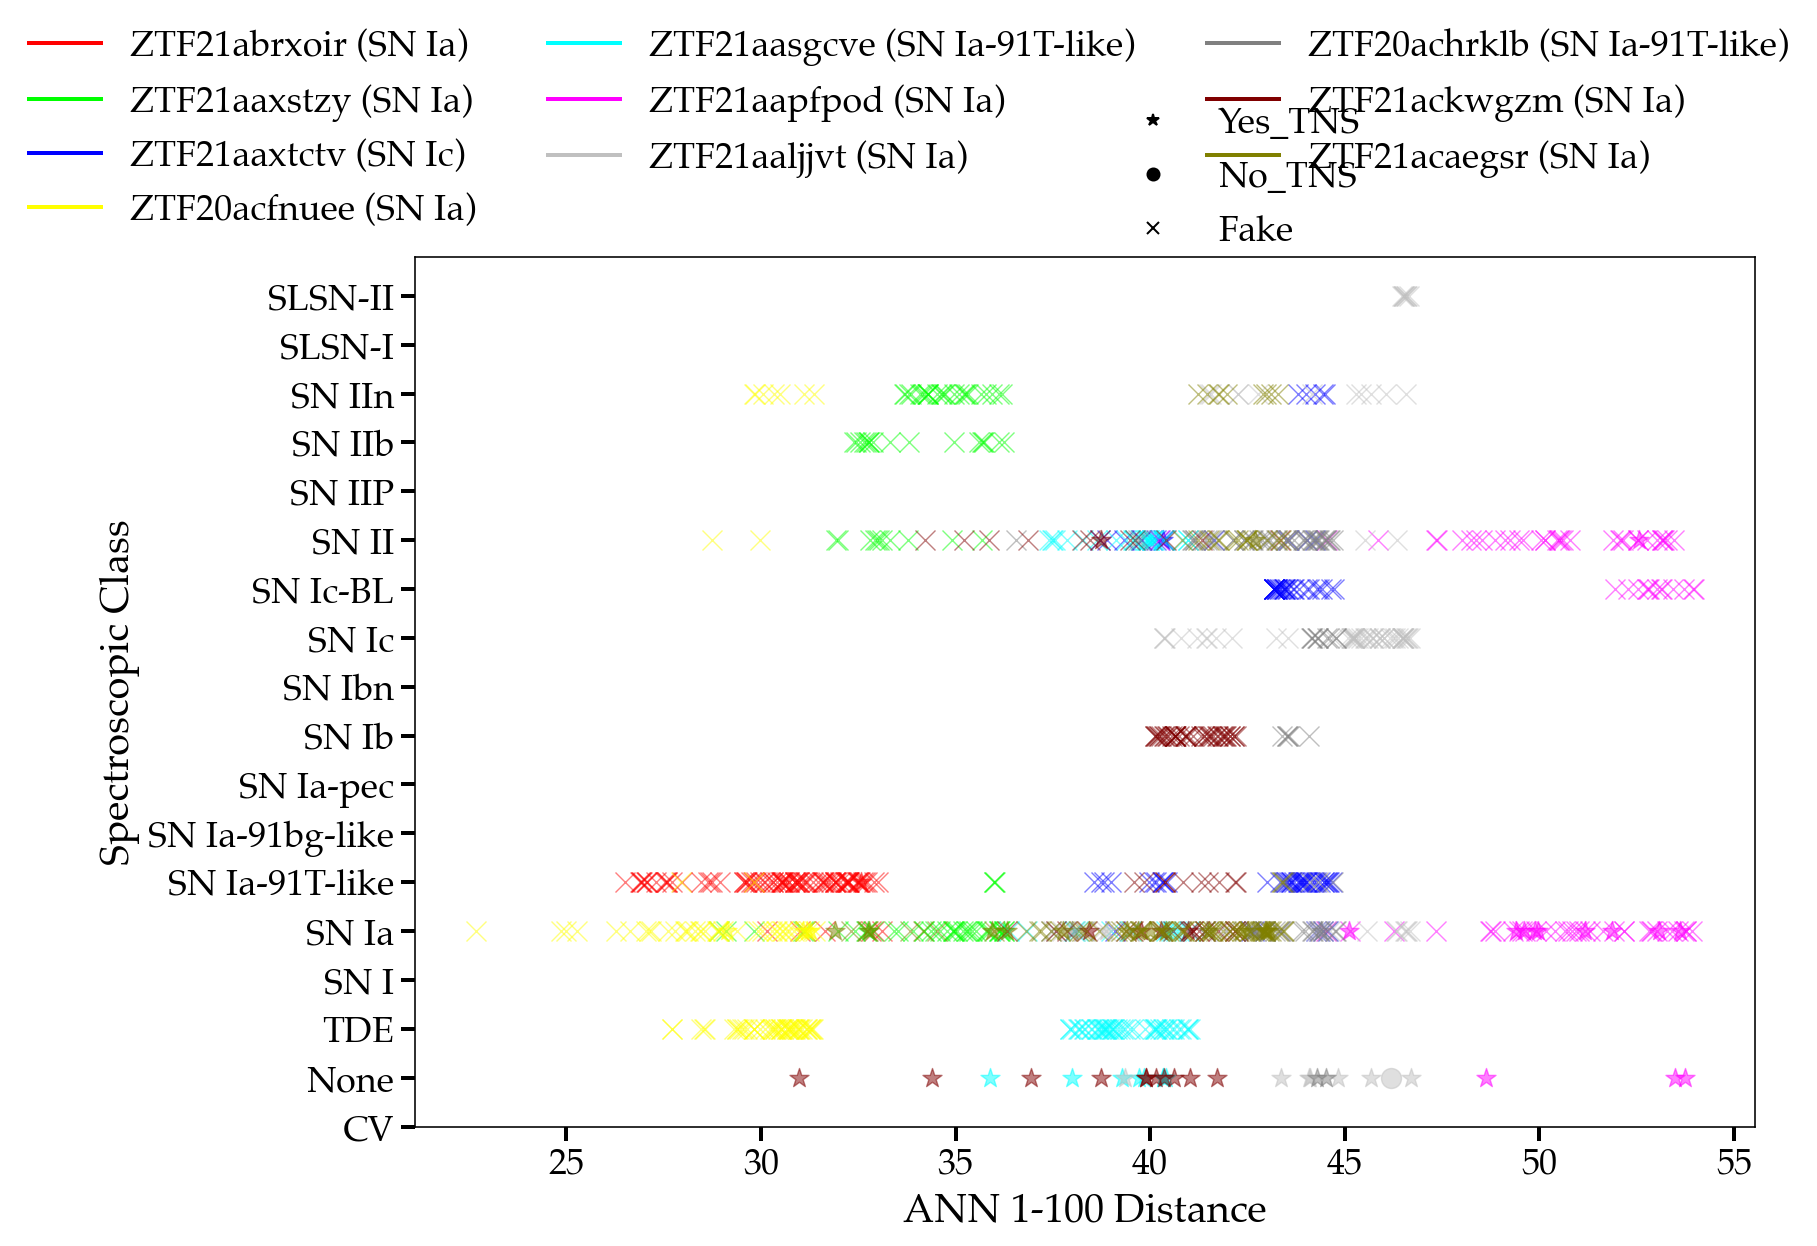

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
ann_columns = ['{}'.format(i) for i in range(1, ann_num)]
distance_columns = ['ann={}_d'.format(ann) for ann in ann_columns]
class_columns = ['ann={}_tns_cls'.format(ann) for ann in ann_columns]
has_tns_columns = ['ann={}_has_tns'.format(ann) for ann in ann_columns]

spec_cls_df = full_ann_properties_df[full_ann_properties_df['ann=0_tns_cls'] != "None"]
df = spec_cls_df.sample(n=10, random_state=1)

#color_list = ['#004c6d', '#a4c2f4', '#006e51', '#87ceeb', '#9b4f0f', '#f4a460', '#d8bfd8', '#c7a317', '#808080', '#e6beff', '#f781bf', '#00ff7f', '#000000', '#808000', '#ffa500', '#7f7f7f', '#6a5acd', '#b22222', '#1e90ff', '#9932cc']
color_list = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#C0C0C0', '#808080', '#800000', '#808000', '#008000', '#800080', '#008080', '#000080', '#FFA500', '#FFC0CB', '#FFD700', '#800080', '#FF69B4', '#00CED1']


# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of the class labels
class_order = ['CV', 'None', 'TDE', 'SN I', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-pec', 'SN Ib', 'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SLSN-I', 'SLSN-II']


color_legend_handles = {}


# Create a dictionary to map each class label to its position in the desired order
class_order_map = {'CV': 0, 'None': 1, 'TDE': 2, 'SN I': 3, 'SN Ia': 4, 'SN Ia-91T-like': 5, 'SN Ia-91bg-like': 6, 'SN Ia-pec': 7, 'SN Ib': 8, 'SN Ibn': 9, 'SN Ic': 10, 'SN Ic-BL': 11, 'SN II': 12, 'SN IIP': 13, 'SN IIb': 14, 'SN IIn': 15, 'SLSN-I': 16, 'SLSN-II': 17}
status_map = {'Yes_TNS': '*', 'No_TNS': 'o', 'Fake': 'x'}

# Iterate over the rows and plot each supernova with a different color and marker symbol
for (index_label, row), color in zip(df.iterrows(), color_list):
    # Get the ANN distances and classes for this row
    distances = row[distance_columns].values
    classes = row[class_columns].values
    #print(index_label, classes)
    ref_cls = row['ann=0_tns_cls']
    status = row[has_tns_columns].values
    print(f"https://alerce.online/object/{index_label}", ref_cls)
    #print(status)
    
    # Get the color for this supernova based on the mapping
    color = color
    
    # Sort the classes based on the desired order
    sorted_classes = [class_order_map[label] for label in classes]
    markers = [status_map[st] for st in status]
    
    #print(index_label, sorted_classes)
    for i in range(len(distances)):
        ax.scatter(distances[i], sorted_classes[i], marker=markers[i], s=100, alpha=0.5, lw=0.7, color=color)
    
    # Add the color handle to the legend dictionary
    color_legend_handles[index_label] = plt.Line2D([], [], color=color, label=f'{index_label} ({ref_cls})')

# Set the y-axis tick labels in the desired order
ax.set_yticks(list(class_order_map.values()))
ax.set_yticklabels(list(class_order_map.keys()))

# Set the axis labels and title
ax.set_xlabel('ANN 1-100 Distance')
ax.set_ylabel('Spectroscopic Class')



# Create the color legend
color_legend = ax.legend(handles=color_legend_handles.values(), ncol=3, bbox_to_anchor=(1.05, 1.3), frameon=False)
ax.add_artist(color_legend)

# Create the marker symbol legend
marker_legend = ax.legend(handles=[plt.Line2D([], [], marker='*', color='k', linestyle='None', label='Yes_TNS'),
                                    plt.Line2D([], [], marker='o', color='k', linestyle='None', label='No_TNS'),
                                    plt.Line2D([], [], marker='x', color='k', linestyle='None', label='Fake')],
                           bbox_to_anchor=(0.5, 0.97), frameon=False)

# Show the plot
plt.savefig(f'../figures/graphs/{suffix}/ANN_vs_class_ann{ann_num}.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [74]:
# https://alerce.online/object/ZTF21acjbgok (CV) - indeed CV
# https://alerce.online/object/ZTF21acfabut (Ia) - indeed looks Ia
# https://alerce.online/object/ZTF21abqvzjy (II) - unusually bright SN II (peak mag ~-19.5). II, Ia, SLSN all kinda make sense
# https://alerce.online/object/ZTF21aaublej (Ia) - indeed Ia norm. Ia-norm / 91T class makes ok sense
# https://alerce.online/object/ZTF21acisqde (Ia) - indeed Ia. SLSN doesn't make sense, but need to check host assoc
# https://alerce.online/object/ZTF20aceokvr (IIn) - totally looks like IIn, not SLSN-II. But not the worst guess
# https://alerce.online/object/ZTF21aaiaqhh (II) - double humped II. Indeed II, but IIb makes ok sense.
# https://alerce.online/object/ZTF22aaaeeva (Ia) - indeed looks more like SN II, not Ia
# https://alerce.online/object/ZTF21abjwvzu (Ia) - indeed looks not Ia, because of bright, closeby, no rise LC
# https://alerce.online/object/ZTF20acitpfz (TDE) -  not great

# Overall results are ok/justifiable

## For #suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" (not v2)

### https://alerce.online/object/ZTF21abowqqa = 2021uga is 91T-like from my SNID analysis!!! Spectrum taken 5d before peak, so maybe that's why shallow Si. But light curve reaches normal Ia peak mag but weak / little / if at all secondary peak

### https://alerce.online/object/ZTF21aahdpvi = 2021ble is Ia-norm but many good SNID matches to 91T like (so not bad)

In [ ]:
df.loc['ZTF21aagkvqa']['ann=6_tns_cls']

In [31]:
np.unique(full_ann_tns_cls_df['ann=0_tns_cls'])

array(['None', 'SLSN-I', 'SLSN-II', 'SN I', 'SN II', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like',
       'SN Ia-pec', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'], dtype=object)

In [ ]:
['None', 'TDE', 'SN I', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-pec', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'SLSN-I', 'SLSN-II']

In [43]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'TDE']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acyydkh,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
ZTF21aabiipy,TDE,None,SN Ia,None,SN Ia,None,None,TDE,TDE,TDE,...,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE


In [44]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaplfah,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like
ZTF21aapomdb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec
ZTF21aahfjlo,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia-pec,SN Ia-pec,SN Ia-pec,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia,SN Ia-pec,SN Ia-pec
ZTF21abcmepi,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
ZTF20acobamg,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,None,SLSN-I,SLSN-I,SLSN-I,...,SN IIn,SLSN-I,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SLSN-I,SLSN-I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20accodxy,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SLSN-II
ZTF21abcnkbe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SN Ia,SLSN-I,SLSN-I
ZTF21absbwyz,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SN Ia,SLSN-II,SN Ia,SN Ia
ZTF21aasafkl,SN Ia,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I,SN I,...,SN I,SN I,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I


In [45]:
full_ann_properties_df.loc['ZTF21aahfjlo']

ann=0_ztfid       ZTF21aahfjlo
ann=1_ztfid       ZTF21aagycrc
ann=2_ztfid       ZTF20actoakx
ann=3_ztfid       ZTF21aapkhsc
ann=4_ztfid        ZTFabc96064
                      ...     
ann=96_spec_z            -99.0
ann=97_spec_z            -99.0
ann=98_spec_z            -99.0
ann=99_spec_z            -99.0
ann=100_spec_z           -99.0
Name: ZTF21aahfjlo, Length: 505, dtype: object